## Dumping Business Data

In [ ]:
import pandas as pd
def parse_json_gz(file_path, num_lines=300):
    """
    Reads a specified number of lines from a JSON file.
    
    Parameters:
        file_path (str): Path to the JSON file.
        num_lines (int): Number of lines to read.
        
    Yields:
        dict: Parsed JSON object.
    """
    with open(file_path, 'r') as f:
        for i, line in enumerate(f):
            if num_lines:
                if i >= num_lines:
                    break
            yield json.loads(line)

file_path = r'C:\MS DS\RG_Winter25\Capstone 1 DSCI 591\data\meta-Pennsylvania.json\meta-Pennsylvania.json'
meta_data = list(parse_json_gz(file_path, num_lines=None))

meta_data = pd.DataFrame(meta_data)

if 'pics' in meta_data.columns:  
    meta_data.drop(columns=['pics'], inplace=True) 

meta_data.to_csv('./data/sample_meta_data.csv', index=False)
meta_data.rename(columns={'name': 'business_name','MISC':'misc'}, inplace=True)
meta_data = meta_data.drop_duplicates(subset=['gmap_id','longitude','latitude'])
meta_data = meta_data.dropna(subset=['gmap_id','longitude','latitude'])
meta_data.head()

,business_name,address,gmap_id,description,latitude,longitude,category,avg_rating,num_of_reviews,price,hours,misc,state,relative_results,url
0,Primo Pizza & Subs,"Primo Pizza & Subs, 148 W St Joseph St, Easton...",0x89c46d5e4554eae1:0xa2f8b211524ca29a,None,40.682177,-75.209820,[Pizza delivery],4.5,25,$$,"[[Thursday, 11AM–9PM], [Friday, 11AM–10PM], [S...","{'Service options': ['No-contact delivery', 'D...",Open ⋅ Closes 9PM,"[0x89c46c56cac9c661:0xdc9d0dd3f2b203ae, 0x89c4...",https://www.google.com/maps/place//data=!4m2!3...
1,S.J. O’Hara Inc.,"S.J. O’Hara Inc., 143 White Oak Ct, Tannersvil...",0x89c48c790b767ec7:0x1943c20a42196a68,None,41.055487,-75.284536,"[HVAC contractor, Air conditioning contractor,...",4.5,8,None,"[[Thursday, 7AM–7PM], [Friday, 7AM–7PM], [Satu...","{'Health & safety': ['Appointment required', '...",Open ⋅ Closes 7PM,"[0x89c48c7bd96b49f9:0xdf562ab873031e1, 0x89c45...",https://www.google.com/maps/place//data=!4m2!3...
2,Vivi Bubble Tea,"Vivi Bubble Tea, 701 S 5th St, Philadelphia, P...",0x89c6c89efcaed69d:0xded973f6033e7dba,"Bubble tea shop offering hot & cold versions, ...",39.940293,-75.150923,[Restaurant],4.0,8,None,None,"{'Service options': ['Delivery'], 'Amenities':...",None,"[0x89c6c62a40f4b733:0x73bfeec1898f272b, 0x89c6...",https://www.google.com/maps/place//data=!4m2!3...
3,Kater Street Bicycle,"Kater Street Bicycle, 609 S 16th St, Philadelp...",0x89c6c63c8cd87141:0x54d0d283872eecbb,None,39.943673,-75.168762,"[Bicycle Shop, Bicycle repair shop]",4.9,15,None,"[[Thursday, 11AM–7PM], [Friday, 2–6PM], [Satur...",None,Permanently closed,"[0x89c6c623342d6197:0x70233738cd92d9b, 0x89c6c...",https://www.google.com/maps/place//data=!4m2!3...
4,Cadence Cycling and Cafe - Center City,"Cadence Cycling and Cafe - Center City, 201 S ...",0x89c6c715d1821fe3:0x9cfa8308c0ce2289,None,39.950078,-75.180729,"[Bicycle Shop, Bicycle repair shop, Coffee sho...",4.8,38,None,"[[Thursday, 7AM–7PM], [Friday, 7AM–7PM], [Satu...","{'Service options': ['In-store pickup', 'In-st...",Open ⋅ Closes 7PM,"[0x89c6c7d1a79d4103:0x2476b0fe30eb0871, 0x89c6...",https://www.google.com/maps/place//data=!4m2!3...


In [3]:
meta_data.shape

(189836, 15)

In [ ]:
def safe_convert_list(value):
    """Convert string representation of lists to actual lists."""
    if isinstance(value, str) and value.startswith("[") and value.endswith("]"):
        try:
            return ast.literal_eval(value)  
        except (SyntaxError, ValueError):
            return value  
    return value

def convert_price(value):
    """Map price symbols to numeric values."""
    price_map = {'$': 1, '$$': 2, '$$$': 3}
    return price_map.get(value, None)  

meta_data['category'] = meta_data['category'].apply(safe_convert_list)
meta_data['relative_results'] = meta_data['relative_results'].apply(safe_convert_list)
meta_data['hours'] = meta_data['hours'].apply(safe_convert_list)

meta_data.replace({'None': None}, inplace=True)

meta_data['price'] = meta_data['price'].apply(convert_price)

meta_data = meta_data.where(pd.notna(meta_data), None)

def serialize_misc(data):
    if isinstance(data, dict):
        return json.dumps(data)  
    return data  

meta_data['misc'] = meta_data['misc'].apply(serialize_misc)

In [ ]:

from tqdm import tqdm

TABLE_NAME = 'business'
CHUNK_SIZE = 5000
def dump_reviews_table(df_reviews):
    """
    Dumps the 'reviews' DataFrame into the PostgreSQL 'reviews' table in chunks,
    with tqdm progress tracking.
    """
    try:
        total_rows = len(df_reviews)
        num_chunks = (total_rows // CHUNK_SIZE) + 1  
        
        for start in tqdm(range(0, total_rows, CHUNK_SIZE), desc="Dumping Data", total=num_chunks):
            chunk = df_reviews.iloc[start: start + CHUNK_SIZE]  
            insert_chunk(chunk, engine, TABLE_NAME)
        
        print(f"Data successfully dumped into table '{TABLE_NAME}' in PostgreSQL!")
    except Exception as e:
        print("Error:", e)

dump_reviews_table(meta_data)


Dumping Data:   8%|▊         | 3/38 [00:00<00:02, 11.69it/s]

Error inserting chunk: (psycopg2.errors.UniqueViolation) duplicate key value violates unique constraint "business_pkey"
DETAIL:  Key (gmap_id)=(0x89c46d5e4554eae1:0xa2f8b211524ca29a) already exists.

[SQL: INSERT INTO business (business_name, address, gmap_id, description, latitude, longitude, category, avg_rating, num_of_reviews, price, hours, misc, state, relative_results, url) VALUES (%(business_name__0)s, %(address__0)s, %(gmap_id__0)s, %(descripti ... 290182 characters truncated ... rice__999)s, %(hours__999)s, %(misc__999)s, %(state__999)s, %(relative_results__999)s, %(url__999)s)]
[parameters: {'price__0': 2.0, 'avg_rating__0': 4.5, 'address__0': 'Primo Pizza & Subs, 148 W St Joseph St, Easton, PA 18042', 'business_name__0': 'Primo Pizza & Subs', 'gmap_id__0': '0x89c46d5e4554eae1:0xa2f8b211524ca29a', 'longitude__0': -75.20981979999999, 'description__0': None, 'state__0': 'Open ⋅ Closes 9PM', 'url__0': 'https://www.google.com/maps/place//data=!4m2!3m1!1s0x89c46d5e4554eae1:0xa2f8b

Dumping Data:  13%|█▎        | 5/38 [00:00<00:02, 11.98it/s]

Error inserting chunk: (psycopg2.errors.UniqueViolation) duplicate key value violates unique constraint "business_pkey"
DETAIL:  Key (gmap_id)=(0x8834f4a8dbff5e31:0xb812cd71d4d089ff) already exists.

[SQL: INSERT INTO business (business_name, address, gmap_id, description, latitude, longitude, category, avg_rating, num_of_reviews, price, hours, misc, state, relative_results, url) VALUES (%(business_name__0)s, %(address__0)s, %(gmap_id__0)s, %(descripti ... 290182 characters truncated ... rice__999)s, %(hours__999)s, %(misc__999)s, %(state__999)s, %(relative_results__999)s, %(url__999)s)]
[parameters: {'price__0': None, 'avg_rating__0': 4.4, 'address__0': 'Flowerama Pittsburgh, 3111 Babcock Blvd, Pittsburgh, PA 15237', 'business_name__0': 'Flowerama Pittsburgh', 'gmap_id__0': '0x8834f4a8dbff5e31:0xb812cd71d4d089ff', 'longitude__0': -80.0134933, 'description__0': 'Florist chain offering plants, special arrangements, balloons & gifts as well as flowers & bouquets.', 'state__0': 'Closed ⋅ 

Dumping Data:  24%|██▎       | 9/38 [00:00<00:02, 12.05it/s]

Error inserting chunk: (psycopg2.errors.UniqueViolation) duplicate key value violates unique constraint "business_pkey"
DETAIL:  Key (gmap_id)=(0x88345e02730ff711:0x6487b5eda8c8c65d) already exists.

[SQL: INSERT INTO business (business_name, address, gmap_id, description, latitude, longitude, category, avg_rating, num_of_reviews, price, hours, misc, state, relative_results, url) VALUES (%(business_name__0)s, %(address__0)s, %(gmap_id__0)s, %(descripti ... 290182 characters truncated ... rice__999)s, %(hours__999)s, %(misc__999)s, %(state__999)s, %(relative_results__999)s, %(url__999)s)]
[parameters: {'price__0': None, 'avg_rating__0': 4.5, 'address__0': 'Wolcott Park, 488-498 Broad St, Sewickley, PA 15143', 'business_name__0': 'Wolcott Park', 'gmap_id__0': '0x88345e02730ff711:0x6487b5eda8c8c65d', 'longitude__0': -80.1803978, 'description__0': None, 'state__0': None, 'url__0': 'https://www.google.com/maps/place//data=!4m2!3m1!1s0x88345e02730ff711:0x6487b5eda8c8c65d?authuser=-1&hl=en&gl

Dumping Data:  29%|██▉       | 11/38 [00:00<00:02, 12.24it/s]

Error inserting chunk: (psycopg2.errors.UniqueViolation) duplicate key value violates unique constraint "business_pkey"
DETAIL:  Key (gmap_id)=(0x89c65ee212824061:0xf98cbb6ab32f5122) already exists.

[SQL: INSERT INTO business (business_name, address, gmap_id, description, latitude, longitude, category, avg_rating, num_of_reviews, price, hours, misc, state, relative_results, url) VALUES (%(business_name__0)s, %(address__0)s, %(gmap_id__0)s, %(descripti ... 290182 characters truncated ... rice__999)s, %(hours__999)s, %(misc__999)s, %(state__999)s, %(relative_results__999)s, %(url__999)s)]
[parameters: {'price__0': None, 'avg_rating__0': 5.0, 'address__0': 'Butler Balancing, 1657 Bondsville Rd, Downingtown, PA 19335', 'business_name__0': 'Butler Balancing', 'gmap_id__0': '0x89c65ee212824061:0xf98cbb6ab32f5122', 'longitude__0': -75.76119229999999, 'description__0': None, 'state__0': None, 'url__0': 'https://www.google.com/maps/place//data=!4m2!3m1!1s0x89c65ee212824061:0xf98cbb6ab32f5122?a

Dumping Data:  34%|███▍      | 13/38 [00:01<00:04,  5.15it/s]

Error inserting chunk: (psycopg2.errors.UniqueViolation) duplicate key value violates unique constraint "business_pkey"
DETAIL:  Key (gmap_id)=(0x88327f3d4e63a3a1:0x4a668df35dd600e3) already exists.

[SQL: INSERT INTO business (business_name, address, gmap_id, description, latitude, longitude, category, avg_rating, num_of_reviews, price, hours, misc, state, relative_results, url) VALUES (%(business_name__0)s, %(address__0)s, %(gmap_id__0)s, %(descripti ... 290182 characters truncated ... rice__999)s, %(hours__999)s, %(misc__999)s, %(state__999)s, %(relative_results__999)s, %(url__999)s)]
[parameters: {'price__0': None, 'avg_rating__0': 4.4, 'address__0': 'Petra Restaurant, 3602 W Lake Rd, Erie, PA 16505', 'business_name__0': 'Petra Restaurant', 'gmap_id__0': '0x88327f3d4e63a3a1:0x4a668df35dd600e3', 'longitude__0': -80.1660955, 'description__0': None, 'state__0': 'Permanently closed', 'url__0': 'https://www.google.com/maps/place//data=!4m2!3m1!1s0x88327f3d4e63a3a1:0x4a668df35dd600e3?aut

Dumping Data:  45%|████▍     | 17/38 [00:02<00:02,  7.41it/s]

Error inserting chunk: (psycopg2.errors.UniqueViolation) duplicate key value violates unique constraint "business_pkey"
DETAIL:  Key (gmap_id)=(0x89c6ad715182c341:0xcc05d5bd34416280) already exists.

[SQL: INSERT INTO business (business_name, address, gmap_id, description, latitude, longitude, category, avg_rating, num_of_reviews, price, hours, misc, state, relative_results, url) VALUES (%(business_name__0)s, %(address__0)s, %(gmap_id__0)s, %(descripti ... 290182 characters truncated ... rice__999)s, %(hours__999)s, %(misc__999)s, %(state__999)s, %(relative_results__999)s, %(url__999)s)]
[parameters: {'price__0': None, 'avg_rating__0': 3.0, 'address__0': 'Quality Abstract Services Inc, 605 Louis Dr Ste 509, Warminster, PA 18974', 'business_name__0': 'Quality Abstract Services Inc', 'gmap_id__0': '0x89c6ad715182c341:0xcc05d5bd34416280', 'longitude__0': -75.08602719999999, 'description__0': None, 'state__0': None, 'url__0': 'https://www.google.com/maps/place//data=!4m2!3m1!1s0x89c6ad7151

Dumping Data:  50%|█████     | 19/38 [00:02<00:02,  8.38it/s]

Error inserting chunk: (psycopg2.errors.UniqueViolation) duplicate key value violates unique constraint "business_pkey"
DETAIL:  Key (gmap_id)=(0x89cb42b200a352a1:0xbb1c7a38acde4d6c) already exists.

[SQL: INSERT INTO business (business_name, address, gmap_id, description, latitude, longitude, category, avg_rating, num_of_reviews, price, hours, misc, state, relative_results, url) VALUES (%(business_name__0)s, %(address__0)s, %(gmap_id__0)s, %(descripti ... 290182 characters truncated ... rice__999)s, %(hours__999)s, %(misc__999)s, %(state__999)s, %(relative_results__999)s, %(url__999)s)]
[parameters: {'price__0': None, 'avg_rating__0': 4.9, 'address__0': 'Woods Spa, 965 Ray Rd, Penn Run, PA 15765', 'business_name__0': 'Woods Spa', 'gmap_id__0': '0x89cb42b200a352a1:0xbb1c7a38acde4d6c', 'longitude__0': -79.030647, 'description__0': None, 'state__0': 'Temporarily closed', 'url__0': 'https://www.google.com/maps/place//data=!4m2!3m1!1s0x89cb42b200a352a1:0xbb1c7a38acde4d6c?authuser=-1&hl=en&

Dumping Data:  61%|██████    | 23/38 [00:02<00:01,  9.73it/s]

Error inserting chunk: (psycopg2.errors.UniqueViolation) duplicate key value violates unique constraint "business_pkey"
DETAIL:  Key (gmap_id)=(0x89cb8c7921baaaab:0x51b5e88d71501d77) already exists.

[SQL: INSERT INTO business (business_name, address, gmap_id, description, latitude, longitude, category, avg_rating, num_of_reviews, price, hours, misc, state, relative_results, url) VALUES (%(business_name__0)s, %(address__0)s, %(gmap_id__0)s, %(descripti ... 290182 characters truncated ... rice__999)s, %(hours__999)s, %(misc__999)s, %(state__999)s, %(relative_results__999)s, %(url__999)s)]
[parameters: {'price__0': None, 'avg_rating__0': 5.0, 'address__0': 'All Wheel Drive, 1942 Tuckahoe Rd, Tyrone, PA 16686', 'business_name__0': 'All Wheel Drive', 'gmap_id__0': '0x89cb8c7921baaaab:0x51b5e88d71501d77', 'longitude__0': -78.3456865, 'description__0': None, 'state__0': 'Closed ⋅ Opens 10AM', 'url__0': 'https://www.google.com/maps/place//data=!4m2!3m1!1s0x89cb8c7921baaaab:0x51b5e88d71501d77?

Dumping Data:  66%|██████▌   | 25/38 [00:02<00:01, 10.26it/s]

Error inserting chunk: (psycopg2.errors.UniqueViolation) duplicate key value violates unique constraint "business_pkey"
DETAIL:  Key (gmap_id)=(0x89cbd2836e5e6659:0x719032ec24952955) already exists.

[SQL: INSERT INTO business (business_name, address, gmap_id, description, latitude, longitude, category, avg_rating, num_of_reviews, price, hours, misc, state, relative_results, url) VALUES (%(business_name__0)s, %(address__0)s, %(gmap_id__0)s, %(descripti ... 290182 characters truncated ... rice__999)s, %(hours__999)s, %(misc__999)s, %(state__999)s, %(relative_results__999)s, %(url__999)s)]
[parameters: {'price__0': None, 'avg_rating__0': 4.2, 'address__0': 'Elkhound Hill, 1907 Mountain House Rd, Waterfall, PA 16689', 'business_name__0': 'Elkhound Hill', 'gmap_id__0': '0x89cbd2836e5e6659:0x719032ec24952955', 'longitude__0': -78.1060959, 'description__0': None, 'state__0': None, 'url__0': 'https://www.google.com/maps/place//data=!4m2!3m1!1s0x89cbd2836e5e6659:0x719032ec24952955?authuser=-1&

Dumping Data:  76%|███████▋  | 29/38 [00:03<00:00, 10.64it/s]

Error inserting chunk: (psycopg2.errors.UniqueViolation) duplicate key value violates unique constraint "business_pkey"
DETAIL:  Key (gmap_id)=(0x89c5197e7cc8a4cb:0x79bec1f01003b6b3) already exists.

[SQL: INSERT INTO business (business_name, address, gmap_id, description, latitude, longitude, category, avg_rating, num_of_reviews, price, hours, misc, state, relative_results, url) VALUES (%(business_name__0)s, %(address__0)s, %(gmap_id__0)s, %(descripti ... 290182 characters truncated ... rice__999)s, %(hours__999)s, %(misc__999)s, %(state__999)s, %(relative_results__999)s, %(url__999)s)]
[parameters: {'price__0': 1.0, 'avg_rating__0': 4.6, 'address__0': "Kelly's Bar, 17 Slope St, Wilkes-Barre, PA 18705", 'business_name__0': "Kelly's Bar", 'gmap_id__0': '0x89c5197e7cc8a4cb:0x79bec1f01003b6b3', 'longitude__0': -75.84745819999999, 'description__0': None, 'state__0': 'Closed ⋅ Opens 5PM', 'url__0': 'https://www.google.com/maps/place//data=!4m2!3m1!1s0x89c5197e7cc8a4cb:0x79bec1f01003b6b3?au

Dumping Data:  82%|████████▏ | 31/38 [00:03<00:00, 10.99it/s]

Error inserting chunk: (psycopg2.errors.UniqueViolation) duplicate key value violates unique constraint "business_pkey"
DETAIL:  Key (gmap_id)=(0x89c6c87f5fd65fa1:0xc0b681e0f2e52559) already exists.

[SQL: INSERT INTO business (business_name, address, gmap_id, description, latitude, longitude, category, avg_rating, num_of_reviews, price, hours, misc, state, relative_results, url) VALUES (%(business_name__0)s, %(address__0)s, %(gmap_id__0)s, %(descripti ... 290182 characters truncated ... rice__999)s, %(hours__999)s, %(misc__999)s, %(state__999)s, %(relative_results__999)s, %(url__999)s)]
[parameters: {'price__0': 2.0, 'avg_rating__0': 4.6, 'address__0': 'Sazon Restaurant & Cafe, 941 Spring Garden St, Philadelphia, PA 19123', 'business_name__0': 'Sazon Restaurant & Cafe', 'gmap_id__0': '0x89c6c87f5fd65fa1:0xc0b681e0f2e52559', 'longitude__0': -75.154375, 'description__0': 'Arepas & other traditional Venezuelan fare, including several gluten-free options. Cash only.', 'state__0': 'Open ⋅ 

Dumping Data:  92%|█████████▏| 35/38 [00:03<00:00, 10.90it/s]

Error inserting chunk: (psycopg2.errors.UniqueViolation) duplicate key value violates unique constraint "business_pkey"
DETAIL:  Key (gmap_id)=(0x89c510832a876cdf:0x7075beef1f190cd5) already exists.

[SQL: INSERT INTO business (business_name, address, gmap_id, description, latitude, longitude, category, avg_rating, num_of_reviews, price, hours, misc, state, relative_results, url) VALUES (%(business_name__0)s, %(address__0)s, %(gmap_id__0)s, %(descripti ... 290182 characters truncated ... rice__999)s, %(hours__999)s, %(misc__999)s, %(state__999)s, %(relative_results__999)s, %(url__999)s)]
[parameters: {'price__0': 1.0, 'avg_rating__0': 3.8, 'address__0': 'Metro by T-Mobile, 18A Gateway Shopping Center, Edwardsville, PA 18704', 'business_name__0': 'Metro by T-Mobile', 'gmap_id__0': '0x89c510832a876cdf:0x7075beef1f190cd5', 'longitude__0': -75.89985659999999, 'description__0': 'Wireless provider supplying phones, no-contract plans, accessories & repair services.', 'state__0': 'Closed ⋅ Ope

Dumping Data: 100%|██████████| 38/38 [00:03<00:00,  9.62it/s]

Error inserting chunk: (psycopg2.errors.UniqueViolation) duplicate key value violates unique constraint "business_pkey"
DETAIL:  Key (gmap_id)=(0x89c8e11b58bc4bf1:0xfbb007771536b147) already exists.

[SQL: INSERT INTO business (business_name, address, gmap_id, description, latitude, longitude, category, avg_rating, num_of_reviews, price, hours, misc, state, relative_results, url) VALUES (%(business_name__0)s, %(address__0)s, %(gmap_id__0)s, %(descripti ... 290182 characters truncated ... rice__999)s, %(hours__999)s, %(misc__999)s, %(state__999)s, %(relative_results__999)s, %(url__999)s)]
[parameters: {'price__0': None, 'avg_rating__0': 5.0, 'address__0': None, 'business_name__0': 'S&A Maintenance Service LLC', 'gmap_id__0': '0x89c8e11b58bc4bf1:0xfbb007771536b147', 'longitude__0': -77.26111949999999, 'description__0': None, 'state__0': None, 'url__0': 'https://www.google.com/maps/place//data=!4m2!3m1!1s0x89c8e11b58bc4bf1:0xfbb007771536b147?authuser=-1&hl=en&gl=us', 'category__0': ['Hand

In [211]:
import warnings
warnings.simplefilter("ignore")
import gzip
import json
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import geopandas as gpd

from collections import Counter

In [213]:
def parse_json_gz(file_path):
        with open(file_path, 'r') as f:
            for line in f:
                yield json.loads(line)

In [440]:
reviews = list(parse_json_gz(r'C:\Users\lipin\ML Projects\Capstone Project Phase 1\Recommender System\SMART Local\data\review-Pennsylvania.json\review-Pennsylvania.json'))


In [215]:
metadata = list(parse_json_gz(r'C:\Users\lipin\ML Projects\Capstone Project Phase 1\Recommender System\SMART Local\data\meta-Pennsylvania.json\meta-Pennsylvania.json'))


In [ ]:


pd.set_option('display.max_columns', None)

reviews = pd.DataFrame(reviews)
metadata = pd.DataFrame(metadata)

object_cols = reviews.select_dtypes(include=['object']).columns


reviews[object_cols] = reviews[object_cols].astype(str)
reviews.drop_duplicates(inplace=True)

object_cols = metadata.select_dtypes(include=['object']).columns


metadata[object_cols] = metadata[object_cols].astype(str)
metadata.drop_duplicates(inplace=True)

print("Reviews DataFrame:")
print(reviews.info())
print("\nMetadata DataFrame:")
print(metadata.info())
def merge_datasets(reviews, metadata, merge_on='gmap_id'):
    return pd.merge(reviews, metadata, on=merge_on, how='left')


object_cols = metadata.select_dtypes(include=['object']).columns



merged_data_df = merge_datasets(reviews, metadata)
def handle_missing_values(df, state='PA'):
    drop_subset = ['user_id', 'rating']
    text_columns = ['text', 'description', 'resp']
    categorical_columns = ['name_x', 'name_y', 'category', 'price', 'address', 'hours', 'MISC', 'url']
    
    
    df = df.dropna(subset=drop_subset)

    
    for col in text_columns:
        if col in df.columns:
            df[col] = df[col].fillna("")

    
    for col in categorical_columns:
        if col in df.columns:
            df[col] = df[col].fillna("unknown")
    
    return df
df = handle_missing_values(merged_data_df)
if 'time' in df.columns:
    try:
        df['time'] = pd.to_datetime(df['time'], unit='ms')
    except Exception:
        df['time'] = pd.to_datetime(df['time'], errors='coerce')
numeric_fields = ['rating','user_id', 'avg_rating', 'num_of_reviews', 'latitude', 'longitude']
for field in numeric_fields:
    if field in df.columns:
        df[field] = pd.to_numeric(df[field], errors='coerce')
df.rename(columns={'name_x': 'customer_name', 'name_y': 'business_name'}, inplace=True)


In [15]:
df.head()

,user_id,customer_name,time,rating,text,pics,resp,gmap_id,business_name,address,description,latitude,longitude,category,avg_rating,num_of_reviews,price,hours,MISC,state,relative_results,url
0,1.024128e+20,Jennifer Cordón,2021-09-01 20:59:37.304,5.0,Just had the German pizza. They made it exactl...,None,None,0x89c46d5e4554eae1:0xa2f8b211524ca29a,Primo Pizza & Subs,"Primo Pizza & Subs, 148 W St Joseph St, Easton...",None,40.682177,-75.20982,['Pizza delivery'],4.5,25,$$,"[['Thursday', '11AM–9PM'], ['Friday', '11AM–10...","{'Service options': ['No-contact delivery', 'D...",Open ⋅ Closes 9PM,"['0x89c46c56cac9c661:0xdc9d0dd3f2b203ae', '0x8...",https://www.google.com/maps/place//data=!4m2!3...
1,1.033004e+20,Luis Gonzalez,2021-09-02 00:56:12.046,5.0,"Great food, and great service! You should all ...",None,None,0x89c46d5e4554eae1:0xa2f8b211524ca29a,Primo Pizza & Subs,"Primo Pizza & Subs, 148 W St Joseph St, Easton...",None,40.682177,-75.20982,['Pizza delivery'],4.5,25,$$,"[['Thursday', '11AM–9PM'], ['Friday', '11AM–10...","{'Service options': ['No-contact delivery', 'D...",Open ⋅ Closes 9PM,"['0x89c46c56cac9c661:0xdc9d0dd3f2b203ae', '0x8...",https://www.google.com/maps/place//data=!4m2!3...
2,1.047158e+20,Jasson Cordon,2021-09-07 11:05:28.526,5.0,Good food and fair prices I Just Order a pizza...,None,None,0x89c46d5e4554eae1:0xa2f8b211524ca29a,Primo Pizza & Subs,"Primo Pizza & Subs, 148 W St Joseph St, Easton...",None,40.682177,-75.20982,['Pizza delivery'],4.5,25,$$,"[['Thursday', '11AM–9PM'], ['Friday', '11AM–10...","{'Service options': ['No-contact delivery', 'D...",Open ⋅ Closes 9PM,"['0x89c46c56cac9c661:0xdc9d0dd3f2b203ae', '0x8...",https://www.google.com/maps/place//data=!4m2!3...
3,1.077288e+20,Sharon Mendez,2021-09-01 01:43:59.875,5.0,Very good service and delicious food. I recomm...,None,None,0x89c46d5e4554eae1:0xa2f8b211524ca29a,Primo Pizza & Subs,"Primo Pizza & Subs, 148 W St Joseph St, Easton...",None,40.682177,-75.20982,['Pizza delivery'],4.5,25,$$,"[['Thursday', '11AM–9PM'], ['Friday', '11AM–10...","{'Service options': ['No-contact delivery', 'D...",Open ⋅ Closes 9PM,"['0x89c46c56cac9c661:0xdc9d0dd3f2b203ae', '0x8...",https://www.google.com/maps/place//data=!4m2!3...
4,1.087975e+20,Salvador Fuentes,2021-08-31 18:44:50.430,5.0,Great food and service. Best pizza l ever had.,None,None,0x89c46d5e4554eae1:0xa2f8b211524ca29a,Primo Pizza & Subs,"Primo Pizza & Subs, 148 W St Joseph St, Easton...",None,40.682177,-75.20982,['Pizza delivery'],4.5,25,$$,"[['Thursday', '11AM–9PM'], ['Friday', '11AM–10...","{'Service options': ['No-contact delivery', 'D...",Open ⋅ Closes 9PM,"['0x89c46c56cac9c661:0xdc9d0dd3f2b203ae', '0x8...",https://www.google.com/maps/place//data=!4m2!3...


In [17]:
df.to_csv("./dataclean.csv")

In [ ]:
object_cols = df.select_dtypes(include=['object']).columns


df[object_cols] = df[object_cols].astype(str)

columns_to_fix = df[object_cols] 
for col in columns_to_fix:
    df[col] = df[col].astype(str).str.replace("\x00", "", regex=True)

In [21]:
df.drop_duplicates(inplace=True)

In [ ]:

df.drop(df[df["longitude"] > -70].index, inplace = True)

df.drop(df[df["longitude"] < -80].index, inplace = True)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18983693 entries, 0 to 21712797
Data columns (total 22 columns):
 #   Column            Dtype         
---  ------            -----         
 0   user_id           float64       
 1   customer_name     object        
 2   time              datetime64[ns]
 3   rating            float64       
 4   text              object        
 5   pics              object        
 6   resp              object        
 7   gmap_id           object        
 8   business_name     object        
 9   address           object        
 10  description       object        
 11  latitude          float64       
 12  longitude         float64       
 13  category          object        
 14  avg_rating        float64       
 15  num_of_reviews    int64         
 16  price             object        
 17  hours             object        
 18  MISC              object        
 19  state             object        
 20  relative_results  object        
 21  url        

In [ ]:
df_new = df.drop(columns=['category', 'hours', 'MISC', 'relative_results','pics'])

df_new = df_new.sort_values(by='time', ascending=True)

df_new = df_new.reset_index(drop=True).rename_axis('id').reset_index()

df_new.head()


,id,user_id,customer_name,time,rating,text,resp,gmap_id,business_name,address,description,latitude,longitude,avg_rating,num_of_reviews,price,state,url
0,0,1.082528e+20,Hardeep chawla,1990-12-31,5.0,Finally a gastronomic experienece in Bucks cou...,None,0x89c15651a5aee36d:0xf7cdbf7dc059c957,Charcoal BYOB,"Charcoal BYOB, 11 S Delaware Ave, Yardley, PA ...","Creative, market-driven fare & river views are...",40.244506,-74.835622,4.6,513,$$,Closed ⋅ Opens 8AM,https://www.google.com/maps/place//data=!4m2!3...
1,1,1.064611e+20,Tim Downey,1990-12-31,4.0,"Good, traditional steakhouse. Professional se...",None,0x89c69441aa31c5b9:0x1bd7bceb16c01aa5,Creed's Seafood & Steaks,"Creed's Seafood & Steaks, 499 N Gulph Rd, King...",Steaks & seafood served in a comfortable setti...,40.089772,-75.413792,4.5,543,$$$,Closed ⋅ Opens 4PM,https://www.google.com/maps/place//data=!4m2!3...
2,2,1.054456e+20,jerrilyn marston,1990-12-31,4.0,"Price adjusted, one of the best deals in the c...",None,0x89c6c60f6cd77ad1:0x360ab91a846d0252,Tre Scalini,"Tre Scalini, 1915 E Passyunk Ave, Philadelphia...",Homemade pastas & other regional & traditional...,39.926207,-75.167524,4.6,98,$$$,Opens soon ⋅ 5PM,https://www.google.com/maps/place//data=!4m2!3...
3,3,1.073658e+20,Orange Sky,1990-12-31,4.0,None,None,0x89c6c61c1958c901:0xa2a4c589ef72ebc3,Geno's Steaks,"Geno's Steaks, 1219 S 9th St, Philadelphia, PA...",Diehards line up 24/7 for the cheesesteaks ser...,39.933824,-75.158839,4.0,9440,$$,Open 24 hours,https://www.google.com/maps/place//data=!4m2!3...
4,4,1.088639e+20,Paul Kandel,1990-12-31,5.0,Good Asian Fushion cooking. Outdoor patio is ...,None,0x89c6953ed728f5b1:0x6ec7bda050831b1f,Susanna Foo,"Susanna Foo, 555 Lancaster Ave, Radnor, PA 19087",Innovative Pan-Asian dishes prepared using cla...,40.041417,-75.367963,3.8,8,$$$,Permanently closed,https://www.google.com/maps/place//data=!4m2!3...


In [31]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18983693 entries, 0 to 18983692
Data columns (total 18 columns):
 #   Column          Dtype         
---  ------          -----         
 0   id              int64         
 1   user_id         float64       
 2   customer_name   object        
 3   time            datetime64[ns]
 4   rating          float64       
 5   text            object        
 6   resp            object        
 7   gmap_id         object        
 8   business_name   object        
 9   address         object        
 10  description     object        
 11  latitude        float64       
 12  longitude       float64       
 13  avg_rating      float64       
 14  num_of_reviews  int64         
 15  price           object        
 16  state           object        
 17  url             object        
dtypes: datetime64[ns](1), float64(5), int64(2), object(10)
memory usage: 2.5+ GB


In [ ]:

import pandas as pd
from sqlalchemy import create_engine
from concurrent.futures import ThreadPoolExecutor


DB_HOST = "localhost"  
DB_PORT = "5432"  
DB_NAME = "Capstone"
DB_USER = "postgres"
DB_PASSWORD = "Google#13"
TABLE_NAME = "main"
CHUNK_SIZE = 600  


engine = create_engine(f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}")



def insert_chunk(chunk, engine, table_name):
    """
    Inserts a chunk of pandas DataFrame rows into a table in the given database engine.
    """
    try:
        
        chunk.to_sql(table_name, engine, if_exists="append", index=False)
    except Exception as e:
        print(f"Error inserting chunk: {e}")



try:
    total_rows = len(df_new)
    for start in range(0, total_rows, CHUNK_SIZE):
        
        chunk = df_new.iloc[start: start + CHUNK_SIZE]
        insert_chunk(chunk, engine, TABLE_NAME)
    print(f"Data successfully dumped to table '{TABLE_NAME}' in PostgreSQL!")
except Exception as e:
    print("Error:", e)


Data successfully dumped to table 'main' in PostgreSQL!


In [ ]:
import pandas as pd
from sqlalchemy import create_engine


DB_HOST = "localhost"  
DB_PORT = "5432"  
DB_NAME = "Capstone"
DB_USER = "postgres"
DB_PASSWORD = "Google#13"
TABLE_NAME = "main"
CHUNK_SIZE = 600  


engine = create_engine(f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}")


query = "SELECT user_id,time,gmap_id,business_name,description,state,text,rating,latitude,longitude,avg_rating,num_of_reviews FROM public.main;"


df = pd.read_sql(query, engine)


df.head()


,user_id,time,gmap_id,business_name,description,state,text,rating,latitude,longitude,avg_rating,num_of_reviews
0,1.082528e+20,1990-12-31,0x89c15651a5aee36d:0xf7cdbf7dc059c957,Charcoal BYOB,"Creative, market-driven fare & river views are...",Closed ⋅ Opens 8AM,Finally a gastronomic experienece in Bucks cou...,5.0,40.244506,-74.835622,4.6,513
1,1.064611e+20,1990-12-31,0x89c69441aa31c5b9:0x1bd7bceb16c01aa5,Creed's Seafood & Steaks,Steaks & seafood served in a comfortable setti...,Closed ⋅ Opens 4PM,"Good, traditional steakhouse. Professional se...",4.0,40.089772,-75.413792,4.5,543
2,1.054456e+20,1990-12-31,0x89c6c60f6cd77ad1:0x360ab91a846d0252,Tre Scalini,Homemade pastas & other regional & traditional...,Opens soon ⋅ 5PM,"Price adjusted, one of the best deals in the c...",4.0,39.926207,-75.167524,4.6,98
3,1.073658e+20,1990-12-31,0x89c6c61c1958c901:0xa2a4c589ef72ebc3,Geno's Steaks,Diehards line up 24/7 for the cheesesteaks ser...,Open 24 hours,None,4.0,39.933824,-75.158839,4.0,9440
4,1.088639e+20,1990-12-31,0x89c6953ed728f5b1:0x6ec7bda050831b1f,Susanna Foo,Innovative Pan-Asian dishes prepared using cla...,Permanently closed,Good Asian Fushion cooking. Outdoor patio is ...,5.0,40.041417,-75.367963,3.8,8


In [225]:
metadata_df = df.drop_duplicates(["latitude","longitude"])

In [227]:
metadata_df.drop(metadata_df[metadata_df["longitude"] > -70].index, inplace = True)

metadata_df.drop(metadata_df[metadata_df["longitude"] < -80].index, inplace = True)

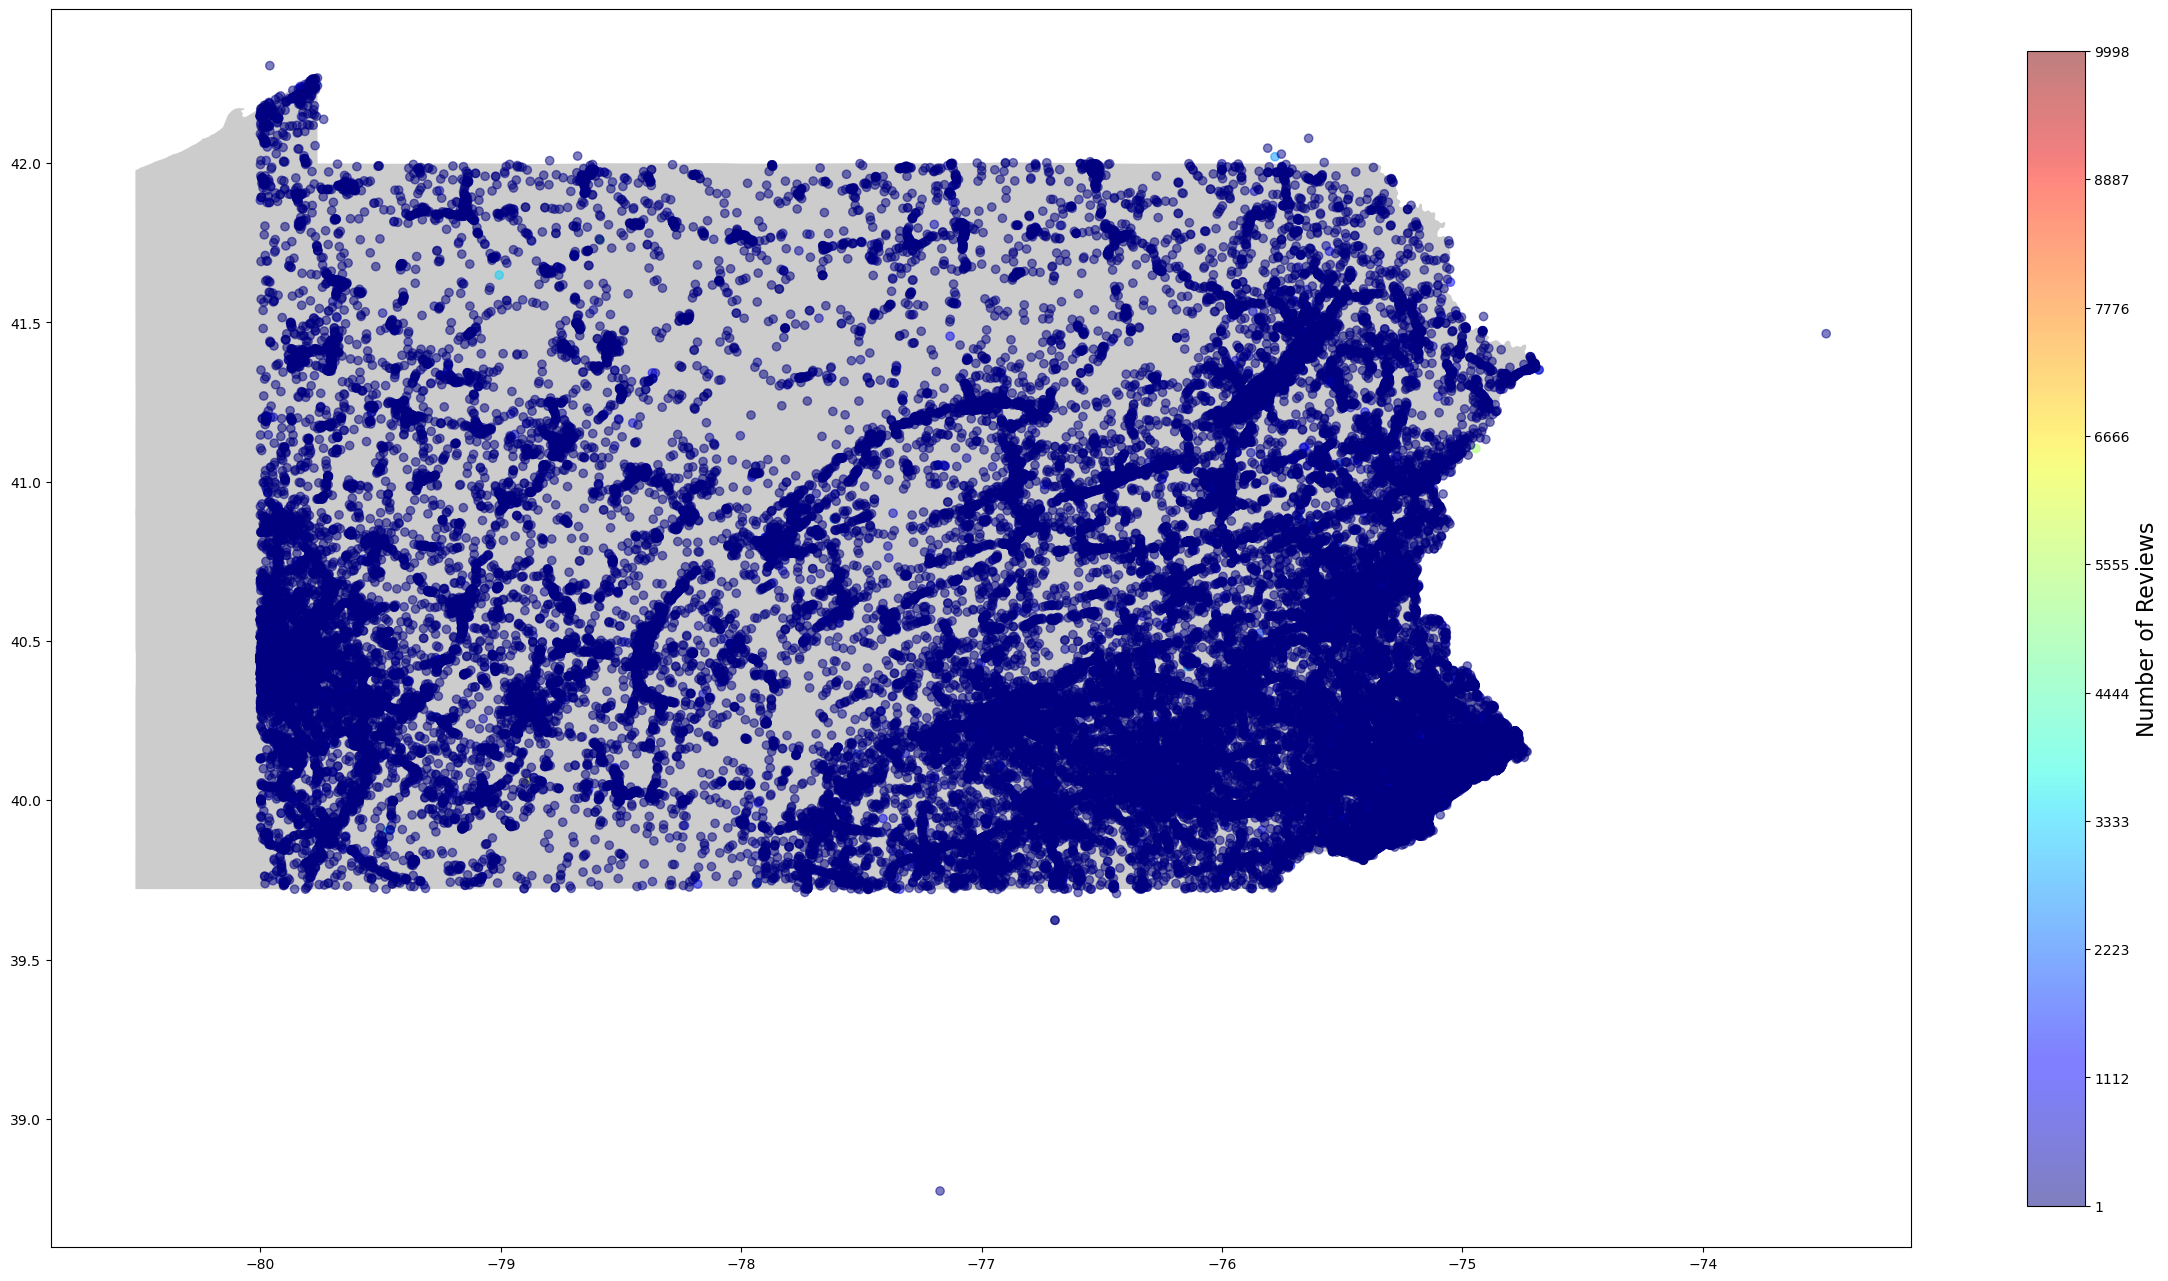

In [229]:

fig, ax=plt.subplots(figsize=(30,30))
pa.plot(ax=ax,legend=True,alpha=0.4, color='grey')
plt.scatter(metadata_df["longitude"],metadata_df["latitude"],c=metadata_df["num_of_reviews"],cmap=plt.get_cmap("jet"),alpha=0.5)
num_reviews = metadata_df["num_of_reviews"]
ticks = np.linspace(num_reviews.min(),num_reviews.max(), num=10)
cbar = plt.colorbar(shrink=0.5)
tick_lables = [round(v) for v in ticks]
cbar.set_ticks(tick_lables)
cbar.set_label('Number of Reviews', fontsize=16)

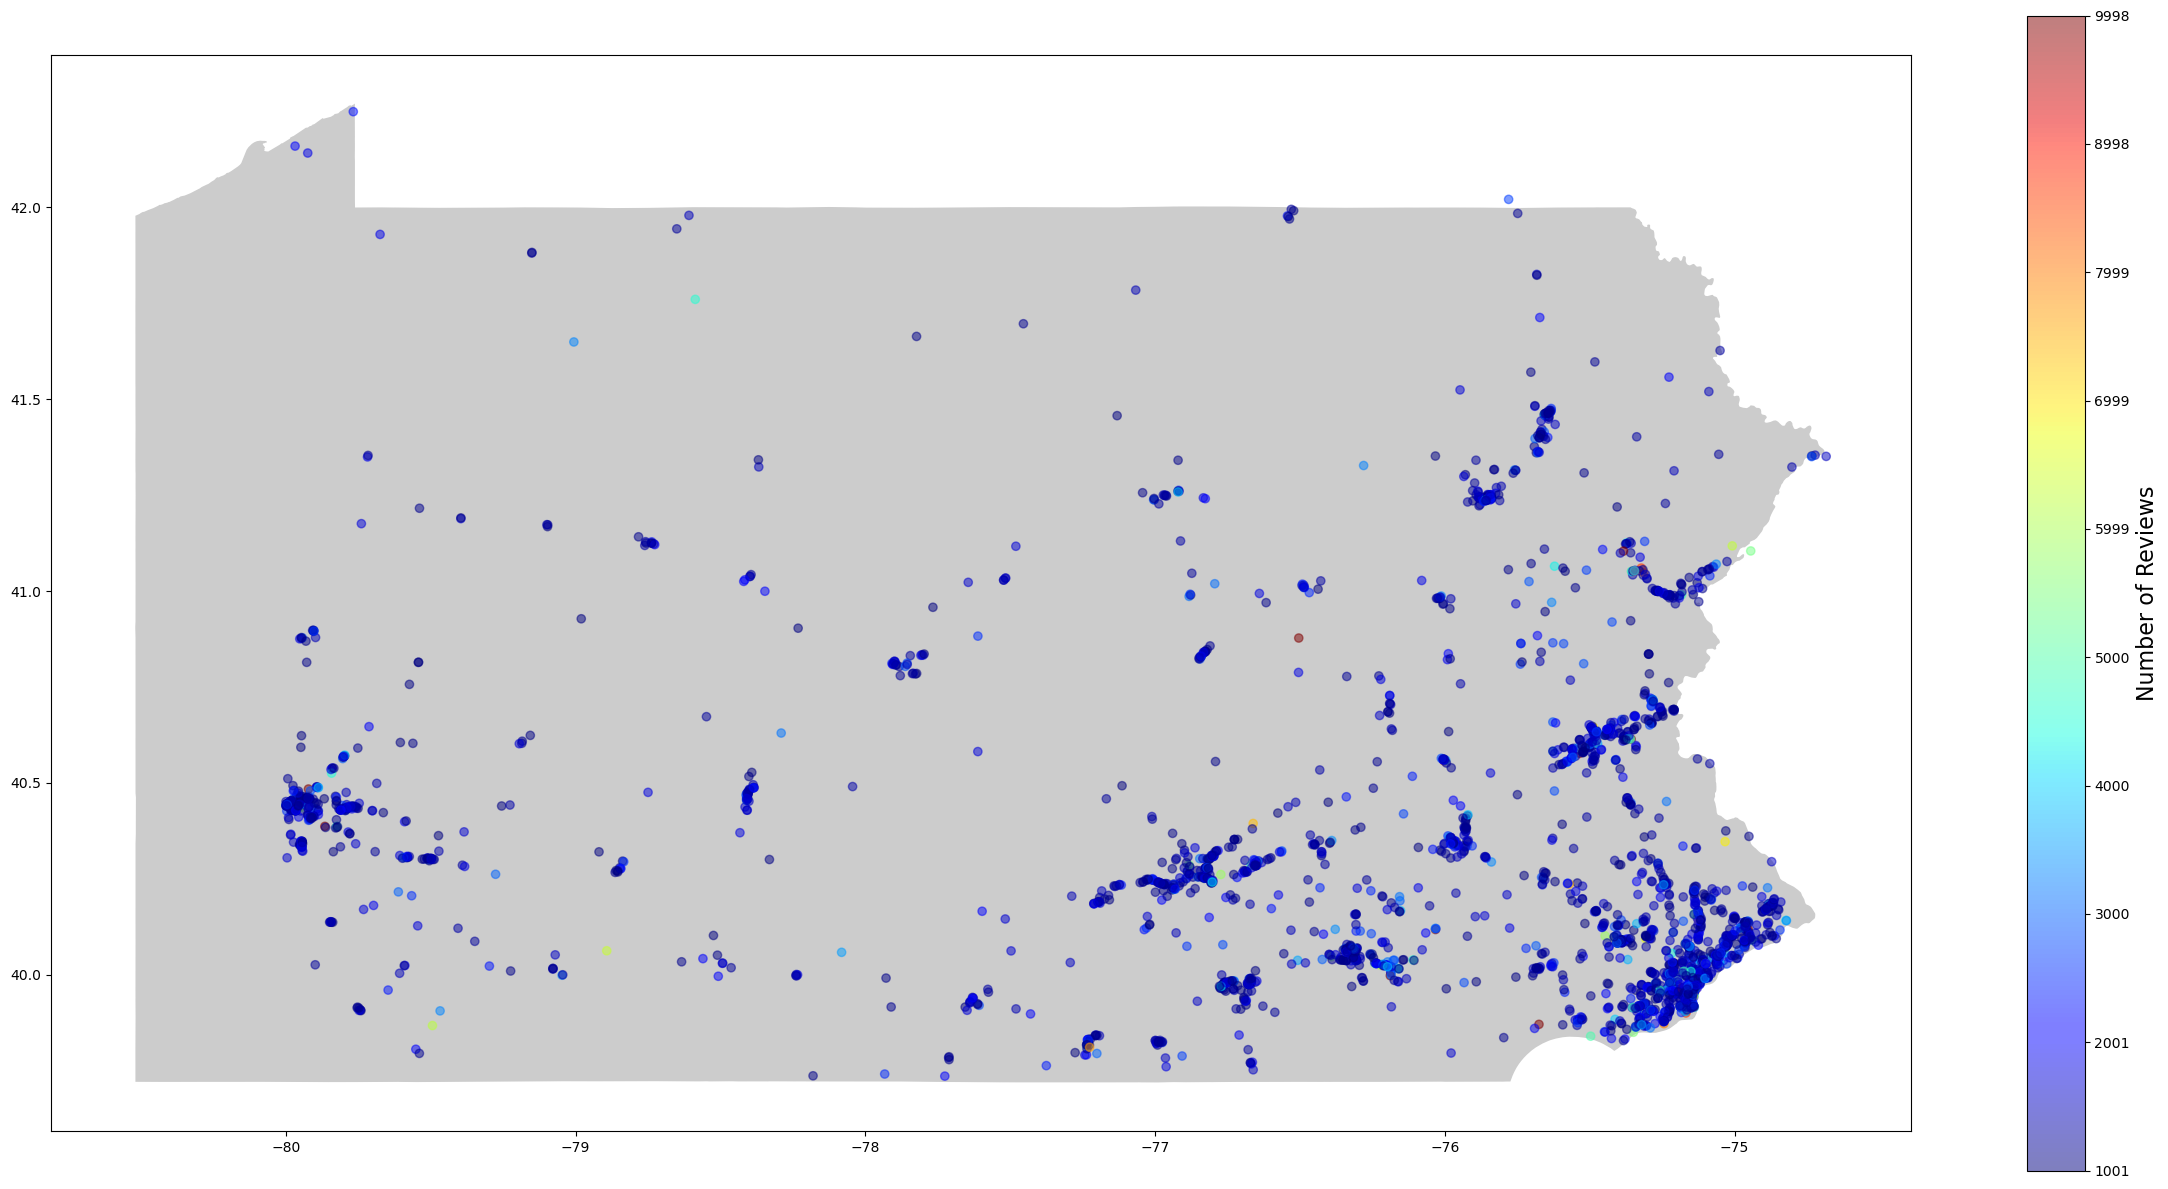

In [23]:
greatorreviews_df = metadata_df[metadata_df["num_of_reviews"]>1000]

fig, ax=plt.subplots(figsize=(30,30))
pa.plot(ax=ax,legend=True,alpha=0.4, color='grey')
plt.scatter(greatorreviews_df["longitude"],greatorreviews_df["latitude"],c=greatorreviews_df["num_of_reviews"],cmap=plt.get_cmap("jet"),alpha=0.5)
num_reviews = greatorreviews_df["num_of_reviews"]
ticks = np.linspace(num_reviews.min(),num_reviews.max(), num=10)
cbar = plt.colorbar(shrink=0.5)
tick_lables = [round(v) for v in ticks]
cbar.set_ticks(tick_lables)
cbar.set_label('Number of Reviews', fontsize=16)

<h2>Business with only one rating catgeory/h2>

In [ ]:
# Find business where are all the reviews rating are same.
businessbyrating = pd.DataFrame(df.groupby(["gmap_id","business_name","rating"]).count()["num_of_reviews"].reset_index())
# Group the above result to find the number of reviews in total
businessiwthonlyonerating = pd.DataFrame(businessbyrating.groupby(["gmap_id"]).count()['num_of_reviews'].reset_index())
#Get business with only one rating in general
business_onerated = businessiwthonlyonerating[businessiwthonlyonerating['num_of_reviews']==1]["gmap_id"]
#Get the details for the above business
businesswithonlyonereview = businessbyrating[businessbyrating['gmap_id'].isin(list(business_onerated))].sort_values(by='num_of_reviews', ascending = False)


In [966]:
businesswithonlyonereview

,gmap_id,business_name,rating,num_of_reviews
438846,0x89c85a2285c0d0d5:0xdad9646a40fa4cb7,David Ross Orthodontics,5.0,628
426806,0x89c6f18a343a49f7:0x88b6a8f6c4be7a3a,Evolution Payroll Services,5.0,401
98678,0x89c375afbf7cd931:0x4d1a993db1983952,The Mobile Cigar Lounge,5.0,265
228912,0x89c627a7edfcfd67:0x9f55d6775e366e9a,Richard Waine Photography,5.0,258
350088,0x89c6c0521368a08d:0x4610e43e98624d27,Faust Orthodontics,5.0,258
...,...,...,...,...
314542,0x89c6b44dd24a42cf:0x54751dfe2c560e81,Above All Auto,5.0,1
43910,0x8834ec679db2ee79:0xc202c379729d28ed,Shining Arrow Associates,5.0,1
480033,0x89c8c3b36891ce91:0x3b28b36448b27a8f,Oyster Mill,5.0,1
479960,0x89c8c3a42bdd8eeb:0x7f8141b552562af8,Grandon Farm Trail,5.0,1


Text(0, 0.5, 'Number of Reviews')

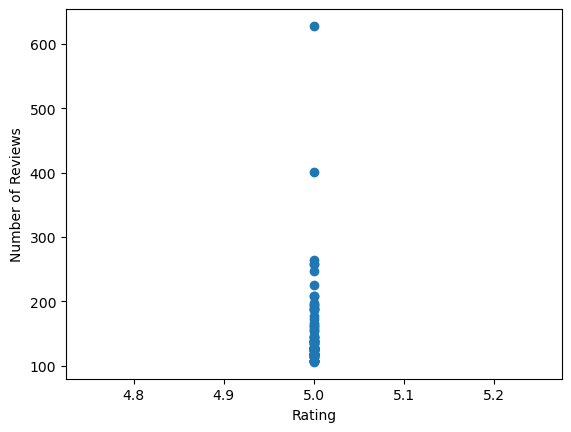

In [912]:
plt.scatter(businesswithonlyonereview.head(75)["rating"],businesswithonlyonereview.head(75)["num_of_reviews"])
plt.xlabel("Rating")
plt.ylabel("Number of Reviews")

<H2>Analyze the influx of reviews over the time period for the top 5 businesses with only positive rating of 5.0</H2>

In [285]:
df["year"] = df['time'].dt.year
businesswithratingbyyear = pd.DataFrame(df.groupby(["gmap_id","year"])['num_of_reviews'].count().reset_index())

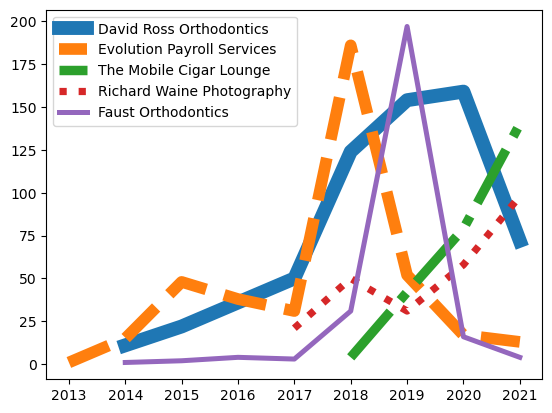

In [ ]:
# Analyze the timing of the review for business

businesstoplot = list(businesswithonlyonereview.head(5)['gmap_id'])


for index,i in enumerate(businesstoplot):
    label = businesswithonlyonereview[businesswithonlyonereview["gmap_id"] == i]['business_name']
    lw=10-8*index/len(businesstoplot)
    ls=['-','--','-.',':'][index%4]
    plt.plot(businesswithratingbyyear[businesswithratingbyyear["gmap_id"] == i]["year"],businesswithratingbyyear[businesswithratingbyyear["gmap_id"] == i]["num_of_reviews"],linestyle=ls, linewidth=lw, label = label)

plt.legend()
plt.show()




<H2>Analyze the influx of reviews over the time period for the top 15 businesses</H2>

In [ ]:
# Doing the same for business with lot of reviews

# business with large number of reviews
hightestratedbusiness = metadata_df.sort_values(by="num_of_reviews", ascending = False)


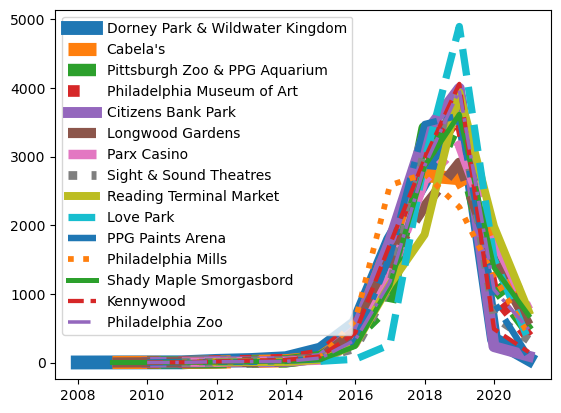

In [ ]:
# Analyze the timing of the review for business over the 8 year period

businesstoplot = list(hightestratedbusiness["gmap_id"][:15])
#colors = ["red","green"]
#plt.figure(figsize=(10, 10))

for index,i in enumerate(businesstoplot):
    label = hightestratedbusiness[hightestratedbusiness["gmap_id"] == i]['business_name']
    lw=10-8*index/len(businesstoplot)
    ls=['-','--','-.',':'][index%4]
    plt.plot(businesswithratingbyyear[businesswithratingbyyear["gmap_id"] == i]["year"],businesswithratingbyyear[businesswithratingbyyear["gmap_id"] == i]["num_of_reviews"],linestyle=ls, linewidth=lw, label = label)

plt.legend()
plt.show()




In [11]:
businessyearwithratingcount = pd.DataFrame(df.groupby(["gmap_id","business_name","year","rating"])['num_of_reviews'].count().reset_index())
businessyearwithratingcount[(businessyearwithratingcount['year'] == 2017) & (businessyearwithratingcount['business_name'] == 'Dorney Park & Wildwater Kingdom')]

,gmap_id,business_name,year,rating,num_of_reviews
387210,0x89c4309b3e647929:0x4ecce74a41b8eb22,Dorney Park & Wildwater Kingdom,2017,1.0,72
387211,0x89c4309b3e647929:0x4ecce74a41b8eb22,Dorney Park & Wildwater Kingdom,2017,2.0,38
387212,0x89c4309b3e647929:0x4ecce74a41b8eb22,Dorney Park & Wildwater Kingdom,2017,3.0,122
387213,0x89c4309b3e647929:0x4ecce74a41b8eb22,Dorney Park & Wildwater Kingdom,2017,4.0,361
387214,0x89c4309b3e647929:0x4ecce74a41b8eb22,Dorney Park & Wildwater Kingdom,2017,5.0,1191


In [13]:
businessyearwithratingcount[(businessyearwithratingcount['year'] == 2018) & (businessyearwithratingcount['business_name'] == 'Dorney Park & Wildwater Kingdom')]

,gmap_id,business_name,year,rating,num_of_reviews
387215,0x89c4309b3e647929:0x4ecce74a41b8eb22,Dorney Park & Wildwater Kingdom,2018,1.0,113
387216,0x89c4309b3e647929:0x4ecce74a41b8eb22,Dorney Park & Wildwater Kingdom,2018,2.0,66
387217,0x89c4309b3e647929:0x4ecce74a41b8eb22,Dorney Park & Wildwater Kingdom,2018,3.0,200
387218,0x89c4309b3e647929:0x4ecce74a41b8eb22,Dorney Park & Wildwater Kingdom,2018,4.0,534
387219,0x89c4309b3e647929:0x4ecce74a41b8eb22,Dorney Park & Wildwater Kingdom,2018,5.0,1741


# 2017 to 2020 are the four years for which dataset has a higher number of reviews


In [ ]:
# Find business with highest number of reviews by same user
df.groupby(["user_id","business_name"]).count()["gmap_id"].sort_values(ascending = False)

user_id       business_name       
1.141328e+20  Weis Markets            81
1.078737e+20  Sheetz                  56
1.087658e+20  Starbucks               54
1.145589e+20  Dollar General          49
1.111387e+20  McDonald's              48
                                      ..
1.062174e+20  TGI Fridays              1
              TOPS Friendly Market     1
              Brinks Home™             1
              Peaceable Kingdom        1
1.184467e+20  Wilkie Lexus             1
Name: gmap_id, Length: 18321029, dtype: int64

In [247]:
metadata_df.groupby(["business_name"]).count().sort_values(by = 'gmap_id',ascending = False)

,user_id,time,gmap_id,description,state,text,rating,latitude,longitude,avg_rating,num_of_reviews
business_name,,,,,,,,,,,
Dollar General,677,677,677,677,677,677,677,677,677,677,677
Subway,622,622,622,622,622,622,622,622,622,622,622
Dunkin',538,538,538,538,538,538,538,538,538,538,538
United States Postal Service,445,445,445,445,445,445,445,445,445,445,445
McDonald's,426,426,426,426,426,426,426,426,426,426,426
...,...,...,...,...,...,...,...,...,...,...,...
Gimbel Field,1,1,1,1,1,1,1,1,1,1,1
Gilson Snow,1,1,1,1,1,1,1,1,1,1,1
Gilpin Rifle Range,1,1,1,1,1,1,1,1,1,1,1


In [249]:
userssamebusinessmultiplereviews = pd.DataFrame(df.groupby(["user_id","business_name","latitude","longitude"]).count()["gmap_id"].sort_values(ascending = False).reset_index())

In [ ]:
userssamebusinessmultiplereviews[userssamebusinessmultiplereviews["gmap_id"]>1]

#Take the latest review and remove all others

,user_id,business_name,latitude,longitude,gmap_id
0,1.141847e+20,ARCannabisClinic.com - Same Day Online Card Ap...,40.994593,-77.604989,3
1,1.091304e+20,Pocono Mountain Villas by Exploria Resorts,41.076850,-75.026198,2
2,1.093564e+20,Philadelphia Dental Associates,39.953289,-75.173645,2
3,1.134716e+20,Pocono Mountain Villas by Exploria Resorts,41.076850,-75.026198,2
4,1.005712e+20,City Cruises Philadelphia,39.941598,-75.141250,2
...,...,...,...,...,...
775,1.150284e+20,Marmont Steakhouse and Bar,39.949878,-75.144574,2
776,1.079580e+20,AutoZone Auto Parts,40.423227,-79.662546,2
777,1.124910e+20,Bourbon Mill,39.861455,-77.072725,2
778,1.107251e+20,Moviltech Cell Phone Repair & Accessories- Cus...,40.272313,-78.856489,2


<h2>#If the user has multiple reviews for the same business, only retain the latest</h2>

'Business with larger than 3000 reviews have a higher average rating'

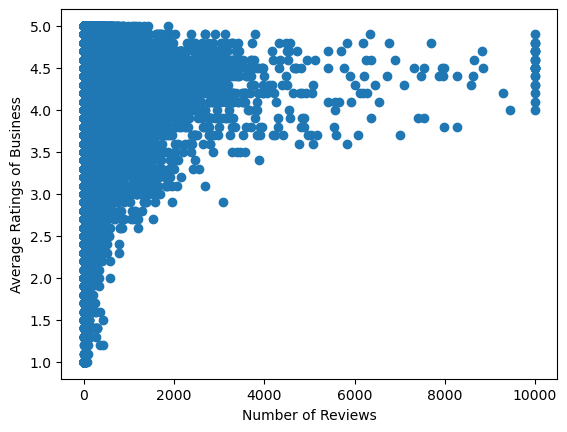

In [ ]:
# analysis between avg_rating and number of reviews of business

plt.scatter(metadata_df["num_of_reviews"], metadata_df["avg_rating"])
plt.xlabel("Number of Reviews")
plt.ylabel("Average Ratings of Business")
"""Business with larger than 3000 reviews have a higher average rating"""


<h1> Univariate Analysis</h1>

{'whiskers': [<matplotlib.lines.Line2D at 0x1dfd8a064b0>,
 'caps': [<matplotlib.lines.Line2D at 0x1dfd8a06ed0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dfd8a06000>],
 'medians': [<matplotlib.lines.Line2D at 0x1dfd8a07b30>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dfd8a24080>],
 'means': []}

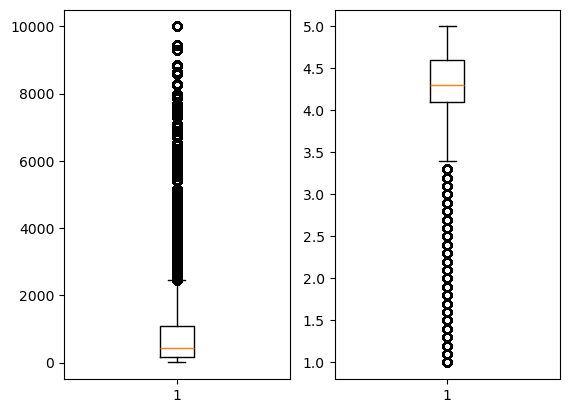

In [221]:
_,ax = plt.subplots(1,2)
ax[0].boxplot(df["num_of_reviews"])
ax[1].boxplot(df["avg_rating"])

In [299]:

df.head()

,user_id,time,gmap_id,business_name,description,state,text,rating,latitude,longitude,avg_rating,num_of_reviews,year
0,1.082528e+20,1990-12-31,0x89c15651a5aee36d:0xf7cdbf7dc059c957,Charcoal BYOB,"Creative, market-driven fare & river views are...",Closed ⋅ Opens 8AM,Finally a gastronomic experienece in Bucks cou...,5.0,40.244506,-74.835622,4.6,513,1990
1,1.064611e+20,1990-12-31,0x89c69441aa31c5b9:0x1bd7bceb16c01aa5,Creed's Seafood & Steaks,Steaks & seafood served in a comfortable setti...,Closed ⋅ Opens 4PM,"Good, traditional steakhouse. Professional se...",4.0,40.089772,-75.413792,4.5,543,1990
2,1.054456e+20,1990-12-31,0x89c6c60f6cd77ad1:0x360ab91a846d0252,Tre Scalini,Homemade pastas & other regional & traditional...,Opens soon ⋅ 5PM,"Price adjusted, one of the best deals in the c...",4.0,39.926207,-75.167524,4.6,98,1990
3,1.073658e+20,1990-12-31,0x89c6c61c1958c901:0xa2a4c589ef72ebc3,Geno's Steaks,Diehards line up 24/7 for the cheesesteaks ser...,Open 24 hours,None,4.0,39.933824,-75.158839,4.0,9440,1990
4,1.088639e+20,1990-12-31,0x89c6953ed728f5b1:0x6ec7bda050831b1f,Susanna Foo,Innovative Pan-Asian dishes prepared using cla...,Permanently closed,Good Asian Fushion cooking. Outdoor patio is ...,5.0,40.041417,-75.367963,3.8,8,1990


In [307]:
df.describe()

,user_id,time,rating,latitude,longitude,avg_rating,num_of_reviews,year
count,1.898369e+07,18983693,1.898369e+07,1.898369e+07,1.898369e+07,1.898369e+07,1.898369e+07,1.898369e+07
mean,1.092152e+20,2019-02-18 02:37:54.104505088,4.283160e+00,4.036093e+01,-7.644805e+01,4.288714e+00,9.782737e+02,2.018635e+03
min,1.000000e+20,1990-12-31 00:00:00,1.000000e+00,3.877363e+01,-8.000000e+01,1.000000e+00,1.000000e+00,1.990000e+03
25%,1.046190e+20,2018-04-12 12:42:27.024999936,4.000000e+00,4.001964e+01,-7.697282e+01,4.100000e+00,1.580000e+02,2.018000e+03
50%,1.091935e+20,2019-03-29 16:13:49.216000,5.000000e+00,4.023282e+01,-7.570169e+01,4.300000e+00,4.380000e+02,2.019000e+03
75%,1.138228e+20,2020-01-27 01:00:55.576999936,5.000000e+00,4.057372e+01,-7.522620e+01,4.600000e+00,1.075000e+03,2.020000e+03
max,1.184467e+20,2021-09-08 20:37:19.739000,5.000000e+00,4.230624e+01,-7.348741e+01,5.000000e+00,9.998000e+03,2.021000e+03
std,5.321418e+18,NaN,1.170901e+00,4.563050e-01,1.601945e+00,4.344048e-01,1.594805e+03,1.411201e+00


In [309]:
low_threshold = 1 + round(4/3) 
high_threshold = 5 - round(4/3)
low_threshold,high_threshold

(2, 4)

In [313]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18983693 entries, 0 to 18983692
Data columns (total 13 columns):
 #   Column          Dtype         
---  ------          -----         
 0   user_id         float64       
 1   time            datetime64[ns]
 2   gmap_id         object        
 3   business_name   object        
 4   description     object        
 5   state           object        
 6   text            object        
 7   rating          float64       
 8   latitude        float64       
 9   longitude       float64       
 10  avg_rating      float64       
 11  num_of_reviews  int64         
 12  year            int32         
dtypes: datetime64[ns](1), float64(5), int32(1), int64(1), object(5)
memory usage: 1.8+ GB


In [315]:
new_df = df.drop(["gmap_id","user_id","description","state","text"], axis =1)

In [319]:
new_df.drop(["business_name"], axis =1, inplace = True)

In [321]:
new_df.corr()

,time,rating,latitude,longitude,avg_rating,num_of_reviews,year
time,1.000000,0.049397,0.022255,-0.004903,0.063169,-0.042750,0.978974
rating,0.049397,1.000000,0.004452,-0.004306,0.370348,0.003913,0.048485
latitude,0.022255,0.004452,1.000000,-0.208054,0.011650,-0.081328,0.020904
longitude,-0.004903,-0.004306,-0.208054,1.000000,-0.010926,0.079617,-0.004500
avg_rating,0.063169,0.370348,0.011650,-0.010926,1.000000,0.010069,0.061041
num_of_reviews,-0.042750,0.003913,-0.081328,0.079617,0.010069,1.000000,-0.044838
year,0.978974,0.048485,0.020904,-0.004500,0.061041,-0.044838,1.000000


<Axes: >

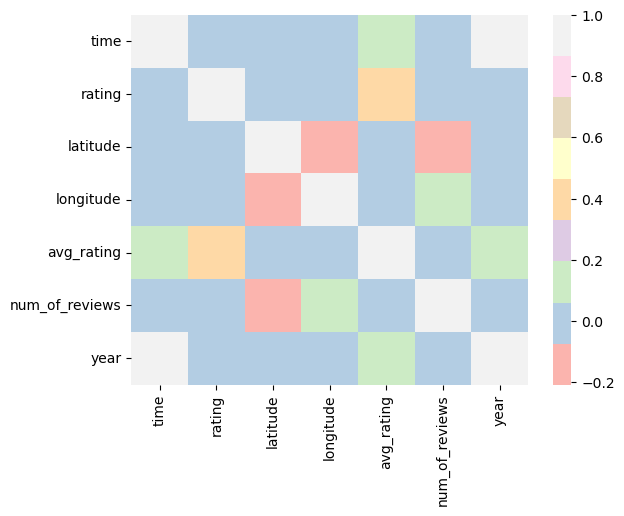

In [323]:
sns.heatmap(new_df.corr(), cmap = 'Pastel1')

EDA Results Analysis

1. Most of the reviews in the systems are from 2016 to 2022. Remove reviews before 2016
2. Users have reviewed same business multiple times, just retain the latest as it shows customers latest preference






In [ ]:
import pandas as pd
from sqlalchemy import create_engine
import math as math
from sqlalchemy import create_engine, Table, MetaData, update

In [ ]:


DB_HOST = "localhost"  
DB_PORT = "5432"  
DB_NAME = "Capstone"
DB_USER = "postgres"
DB_PASSWORD = "Google#13"
TABLE_NAME = "main"
CHUNK_SIZE = 600  


engine = create_engine(f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}")


query = "SELECT * FROM public.user_custom;"


user_custom = pd.read_sql(query, engine)




In [ ]:
user_custom.head()

,totalreviews,totalhighratings,totallowratings,highratingratio,avgratingratio,totalavgrating,lowratingratio,user_id
0,1,1,0,1.000000,0.000000,0,0.000000,1.076758e+20
1,1,0,0,0.000000,1.000000,1,0.000000,1.089765e+20
2,4,4,0,1.000000,0.000000,0,0.000000,1.082284e+20
3,1,1,0,1.000000,0.000000,0,0.000000,1.093459e+20
4,77,58,5,0.753247,0.181818,14,0.064935,1.114635e+20


In [ ]:
def findType(row):
    dist = [math.sqrt((row['lowratingratio'] - 1)**2 + (row['avgratingratio'] - 0)**2+ (row['highratingratio'] - 0)**2),
            math.sqrt((row['lowratingratio'] - 0)**2 + (row['avgratingratio'] - 1)**2+ (row['highratingratio'] - 0)**2),
            math.sqrt((row['lowratingratio'] - 0)**2 + (row['avgratingratio'] - 0)**2+ (row['highratingratio'] - 1)**2)]
    return dist.index(min(dist))

In [ ]:
user_custom["user_type"] = user_custom.apply(findType, axis =1)

In [ ]:
user_custom.head()

,totalreviews,totalhighratings,totallowratings,highratingratio,avgratingratio,totalavgrating,lowratingratio,user_id,user_type
0,1,1,0,1.000000,0.000000,0,0.000000,1.076758e+20,2
1,1,0,0,0.000000,1.000000,1,0.000000,1.089765e+20,1
2,4,4,0,1.000000,0.000000,0,0.000000,1.082284e+20,2
3,1,1,0,1.000000,0.000000,0,0.000000,1.093459e+20,2
4,77,58,5,0.753247,0.181818,14,0.064935,1.114635e+20,2


In [ ]:


DB_HOST = "localhost"  
DB_PORT = "5432"  
DB_NAME = "Capstone"
DB_USER = "postgres"
DB_PASSWORD = "Google#13"
TABLE_NAME = "main"
CHUNK_SIZE = 600  


engine = create_engine(f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}")


query = "SELECT * FROM public.metadata_custom;"


metadata_custom = pd.read_sql(query, engine)




In [ ]:
metadata_custom.head()

,totalreviews,totalhighratings,tottallowratings,totalavgrating,lowratingratio,avgratingratio,highratingratio,gmap_id
0,349,239,4,106,0.011461,0.303725,0.684814,0x8834ee7454a5f2f9:0xae6a4928c1b884f0
1,208,80,41,87,0.197115,0.418269,0.384615,0x8834ee2577d41a0b:0x80d142be1a4e9332
2,36,16,8,12,0.222222,0.333333,0.444444,0x89c4029598a4779f:0xb9bb11d9f816f549
3,47,35,1,11,0.021277,0.234043,0.744681,0x89c6c086f82d79eb:0xe727372e3543d388
4,385,223,17,145,0.044156,0.376623,0.579221,0x89c5ee8a46726027:0x510ad66931ea152e


In [ ]:
metadata_custom["business_type"] = metadata_custom.apply(findType, axis =1)

In [ ]:
metadata_custom.head()

,totalreviews,totalhighratings,tottallowratings,totalavgrating,lowratingratio,avgratingratio,highratingratio,gmap_id,business_type
0,349,239,4,106,0.011461,0.303725,0.684814,0x8834ee7454a5f2f9:0xae6a4928c1b884f0,2
1,208,80,41,87,0.197115,0.418269,0.384615,0x8834ee2577d41a0b:0x80d142be1a4e9332,1
2,36,16,8,12,0.222222,0.333333,0.444444,0x89c4029598a4779f:0xb9bb11d9f816f549,2
3,47,35,1,11,0.021277,0.234043,0.744681,0x89c6c086f82d79eb:0xe727372e3543d388,2
4,385,223,17,145,0.044156,0.376623,0.579221,0x89c5ee8a46726027:0x510ad66931ea152e,2


In [ ]:

import pandas as pd
from sqlalchemy import create_engine
from concurrent.futures import ThreadPoolExecutor


DB_HOST = "localhost"  
DB_PORT = "5432"  
DB_NAME = "Capstone"
DB_USER = "postgres"
DB_PASSWORD = "Google#13"
TABLE_NAME = "metadata_custom_ext"
CHUNK_SIZE = 600  


engine = create_engine(f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}")



def insert_chunk(chunk, engine, table_name):
    """
    Inserts a chunk of pandas DataFrame rows into a table in the given database engine.
    """
    try:
        
        chunk.to_sql(table_name, engine, if_exists="append", index=False)
    except Exception as e:
        print(f"Error inserting chunk: {e}")



try:
    total_rows = len(metadata_custom)
    for start in range(0, total_rows, CHUNK_SIZE):
        
        chunk = metadata_custom.iloc[start: start + CHUNK_SIZE]
        insert_chunk(chunk, engine, TABLE_NAME)
    print(f"Data successfully dumped to table '{TABLE_NAME}' in PostgreSQL!")
except Exception as e:
    print("Error:", e)


Data successfully dumped to table 'metadata_custom_ext' in PostgreSQL!


In [ ]:

import pandas as pd
from sqlalchemy import create_engine
from concurrent.futures import ThreadPoolExecutor


DB_HOST = "localhost"  
DB_PORT = "5432"  
DB_NAME = "Capstone"
DB_USER = "postgres"
DB_PASSWORD = "Google#13"
TABLE_NAME = "userdata_custom_ext"
CHUNK_SIZE = 600  


engine = create_engine(f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}")



def insert_chunk(chunk, engine, table_name):
    """
    Inserts a chunk of pandas DataFrame rows into a table in the given database engine.
    """
    try:
        
        chunk.to_sql(table_name, engine, if_exists="append", index=False)
    except Exception as e:
        print(f"Error inserting chunk: {e}")



try:
    total_rows = len(user_custom)
    for start in range(0, total_rows, CHUNK_SIZE):
        
        chunk = user_custom.iloc[start: start + CHUNK_SIZE]
        insert_chunk(chunk, engine, TABLE_NAME)
    print(f"Data successfully dumped to table '{TABLE_NAME}' in PostgreSQL!")
except Exception as e:
    print("Error:", e)


Data successfully dumped to table 'userdata_custom_ext' in PostgreSQL!


<h2> Appendix </h2>

In [ ]:
import  psycopg2 
  
#Method to create a connection object to the database. 
#It creates a pointer cursor to the database and returns it along with  Connection object 
def create_connection(): 
      #Connect to the Postgresql database using the psycopg2 adapter. 
    #Pass your database name , username , password , hostname and port number 
    conn = psycopg2.connect("dbname='Capstone' user='postgres' password='Google#13' host='localhost' port='5432'") 
    #Get the cursor object from the connection object 
    curr = conn.cursor() 
    return conn,curr 


In [ ]:
create_connection()

(<connection object at 0x0000018694936AC0; dsn: 'user=postgres password=xxx dbname=Capstone host=localhost port=5432', closed: 0>,
 <cursor object at 0x000001869AFC34C0; closed: 0>)

In [ ]:
def updateDeptPoints(deptPoints): 
    try: 
        # Call the create_connection method to get Connection and Cursor objects. 
        conn, curr = create_connection() 
        try: 
            # Prepare the update query as per the columns required 
            deptpoints_update_query = "Update metadata_custom set business_type = %s WHERE  gmap_id = %s"
            # Pass the new values and update query to the executemany() method of Cursor 
            curr.executemany(deptpoints_update_query, deptPoints) 
        except(Exception, psycopg2.Error) as error: 
            # Print Exception in case of error 
            print("Error while updating PostgreSQL table", error) 
        finally: 
            # Close the connection object 
            conn.commit() 
            conn.close() 
    finally: 
        #Since we do not have to do anything in this finally block we will pass 
           pass       
            

In [ ]:
test = [(3,'0x8834ee7454a5f2f9:0xae6a4928c1b884f0')]

In [ ]:
updateDeptPoints(test)

In [ ]:
metadata_custom[["business_type","gmap_id"]][0:10]

,business_type,gmap_id
0,2,0x8834ee7454a5f2f9:0xae6a4928c1b884f0
1,1,0x8834ee2577d41a0b:0x80d142be1a4e9332
2,2,0x89c4029598a4779f:0xb9bb11d9f816f549
3,2,0x89c6c086f82d79eb:0xe727372e3543d388
4,2,0x89c5ee8a46726027:0x510ad66931ea152e
5,2,0x89c46c5a647f247d:0xe29d17509086e312
6,2,0x89c6b9fd18682709:0x9be1c5083f9ab242
7,2,0x89cfa1542ad09db9:0xd529692a85ba094b
8,2,0x89c6c2958d26124d:0x266d22a3f12f7e19
9,1,0x8834c60f0ca8a3b5:0x5147809f7313fcef


In [ ]:
# initialize the Metadata Object
meta = MetaData()
meta.reflect(bind=engine)

In [ ]:
metatable = meta.tables['metadata_custom']

# update

stmt = (update(metatable).where(metatable.c.gmap_id == '0x8834ee7454a5f2f9:0xae6a4928c1b884f0')
            .values(business_type=2))

# Execute the update query using a connection
with engine.connect() as conn:
    result = conn.execute(stmt)
    conn.commit()
    

In [ ]:
result

In [ ]:
conn.commit

<bound method Connection.commit of <sqlalchemy.engine.base.Connection object at 0x00000186938A36E0>>

### Merged from: Final Data Cleaning.ipynb

In [ ]:
import warnings
warnings.simplefilter("ignore")
import gzip
import json
import pandas as pd

pd.set_option('display.max_columns', None)


In [ ]:

def parse_json_gz(file_path):
        with open(file_path, 'r') as f:
            for line in f:
                yield json.loads(line)

reviews = list(parse_json_gz(r'C:\MS DS\RG_Winter25\Capstone 1 DSCI 591\data\review-Pennsylvania.json\review-Pennsylvania.json'))
reviews = pd.DataFrame(reviews)
reviews.drop(columns=['pics'], inplace=True) 



In [ ]:

reviews['time'] = pd.to_datetime(reviews['time'], unit='ms')
reviews = reviews.sort_values(by='time', ascending=True)

object_cols = reviews.select_dtypes(include=['object']).columns
reviews[object_cols] = reviews[object_cols].astype(str)

reviews.drop_duplicates(inplace=True)

def handle_missing_values(df):
    """
    Cleans the dataset by handling missing values:
    - Drops rows where 'user_id', 'text', or 'time' are missing.
    - Fills NaN values in 'text' and 'resp' columns with an empty string.
    """
    drop_subset = ['user_id', 'text', 'time'] 
    text_columns = ['text', 'resp']  
    
    df = df.drop_duplicates(subset=drop_subset)
    df = df.dropna(subset=drop_subset)

    for col in text_columns:
        if col in df.columns:
            df[col] = df[col].fillna("")
    
    return df

reviews["text"] = reviews["text"].str.split("\(Original\)").str[0].str.strip()
        

reviews = handle_missing_values(reviews)

columns_to_fix = reviews[object_cols]
for col in columns_to_fix:
    reviews[col] = reviews[col].astype(str).str.replace("\x00", "", regex=True)

reviews.rename(columns={'name': 'customer_name'}, inplace=True)
reviews = reviews.reset_index(drop=True).rename_axis('id').reset_index()
reviews.head()


,id,user_id,customer_name,time,rating,text,resp,gmap_id
0,0,113859720763765753174,Joe Nicolas,1990-12-31,5.0,None,None,0x89c6c89ada6725cd:0x2479810721359c7
1,1,113513174935774808551,Glenn Vinogradov,1990-12-31,5.0,The best French bistrot outside of France!,None,0x89c6c89e45a8bb15:0x9e89f0fed5054247
2,2,107208310941555070685,Stephen Kossuth,1990-12-31,4.0,None,None,0x89c6f1441b55e805:0xaf705e17955b9e4e
3,3,117887984087038418367,Melody Tsai,1990-12-31,5.0,Great Food!,None,0x89c6c60e85b145bf:0xb189cdb4c35a41f3
4,4,111910324014559174367,Phylis Feiner Johnson,1990-12-31,5.0,Sean is the master of the grill. Imitators bew...,None,0x89c6ed4fea04defb:0x868746dba6d82c78


In [3]:
reviews.shape

(21699421, 8)

In [ ]:
import pandas as pd
from sqlalchemy import create_engine
from concurrent.futures import ThreadPoolExecutor


DB_HOST = "localhost"  
DB_PORT = "5432"  
DB_NAME = "Capstone"  
DB_USER = "postgres"  
DB_PASSWORD = "Google#13"
TABLE_NAME = "reviews"  
CHUNK_SIZE = 400  

engine = create_engine(f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}")

from tqdm import tqdm

def insert_chunk(chunk, engine, table_name):
    """
    Inserts a chunk of pandas DataFrame rows into a PostgreSQL table.
    """
    try:
        chunk.to_sql(table_name, engine, if_exists="append", index=False)
    except Exception as e:
        print(f"Error inserting chunk: {e}")

def dump_reviews_table(df_reviews):
    """
    Dumps the 'reviews' DataFrame into the PostgreSQL 'reviews' table in chunks,
    with tqdm progress tracking.
    """
    try:
        total_rows = len(df_reviews)
        num_chunks = (total_rows // CHUNK_SIZE) + 1  
        
        for start in tqdm(range(0, total_rows, CHUNK_SIZE), desc="Dumping Data", total=num_chunks):
            chunk = df_reviews.iloc[start: start + CHUNK_SIZE]  
            insert_chunk(chunk, engine, TABLE_NAME)
        
        print(f"Data successfully dumped into table '{TABLE_NAME}' in PostgreSQL!")
    except Exception as e:
        print("Error:", e)

dump_reviews_table(reviews)



In [6]:
reviews = None

### Merged from: Priyanka EDA.ipynb

In [ ]:
from sqlalchemy import create_engine, text
from sqlalchemy.orm import sessionmaker

# Database connection settings.
DB_HOST = "192.168.1.103"
DB_PORT = "5432"
DB_NAME = "Capstone"
DB_USER = "postgres"
DB_PASSWORD = "Google#13"

# Create engine and session.
engine = create_engine(
    f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}",
    pool_size=20,
    max_overflow=40
)
Session = sessionmaker(bind=engine)
session = Session()

In [2]:
from sqlalchemy import create_engine, MetaData, Table
from sqlalchemy.orm import sessionmaker
import matplotlib.pyplot as plt
import pandas as pd


In [3]:
import pandas as pd

query = 'SELECT user_id, avg(avg_rating) as "avg_rating", avg(sentiment_avg_score)* 4 + 1 as "sentiment_avg_score" FROM Users group by user_id'

temp =pd.read_sql(query,engine)
print(temp.head())

                 user_id  avg_rating  sentiment_avg_score
0  116390979512265611815         5.0                3.400
1  116386659484463717710         1.0                2.368
2  115750975919940254498         5.0                3.400
3  114542487703040567051         5.0                3.136
4  115755199324384319852         5.0                4.636


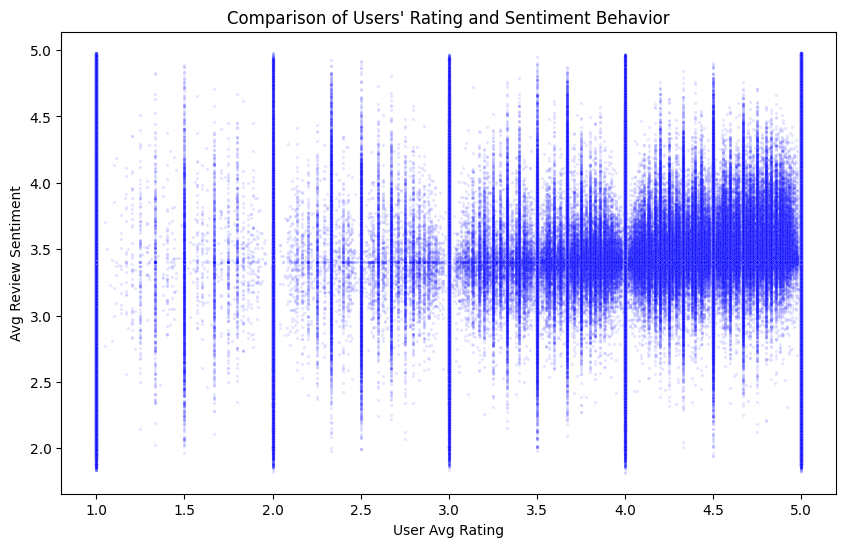

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=temp['avg_rating'],
    y=temp['sentiment_avg_score'],
    s=5,  
    alpha=0.1,  
    color='blue' 
)
plt.title('Comparison of Users\' Rating and Sentiment Behavior')
plt.xlabel('User Avg Rating')
plt.ylabel('Avg Review Sentiment')
plt.show()


### Merged from: RG_main_eda.ipynb

In [ ]:
from sqlalchemy import create_engine, text
from sqlalchemy.orm import sessionmaker

# Database connection settings.
DB_HOST = "192.168.1.103"
DB_PORT = "5432"
DB_NAME = "Capstone"
DB_USER = "postgres"
DB_PASSWORD = "Google#13"

# Create engine and session.
engine = create_engine(
    f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}",
    pool_size=20,
    max_overflow=40
)
Session = sessionmaker(bind=engine)
session = Session()

In [15]:
from sqlalchemy import create_engine, MetaData, Table
from sqlalchemy.orm import sessionmaker
import matplotlib.pyplot as plt
import pandas as pd


                 user_id  user_lifetime_days review_frequency avg_rating
0  118446717614999951016                   1             1.00       5.00
1  118446725185281394757                   1             1.00       3.00
2  118446696946959024765                   1             1.00       1.00
3  118446703820689773600                   1             1.00       5.00
4  118446683655957264030                   1             1.00       5.00


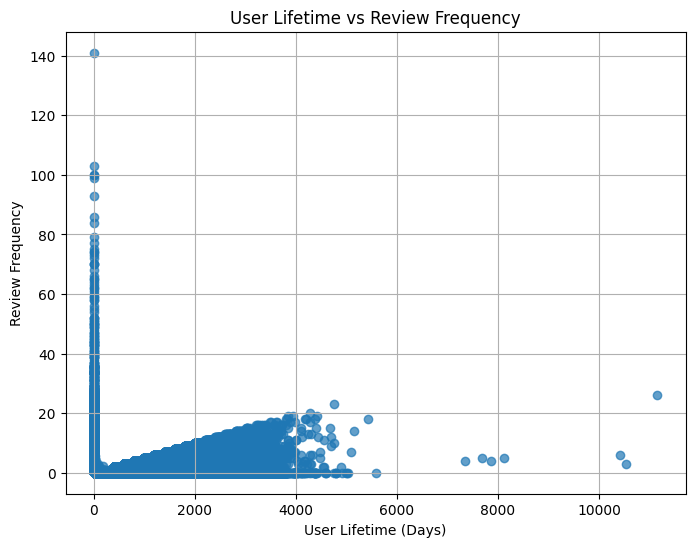

In [ ]:

metadata = MetaData()
users = Table('users', metadata, autoload_with=engine)
query = session.query(
    users.c.user_id,
    users.c.user_lifetime_days,
    users.c.review_frequency,
    users.c.avg_rating
)
results = query.all()

df = pd.DataFrame(results, columns=["user_id", "user_lifetime_days", "review_frequency",'avg_rating'])
print(df.head())

plt.figure(figsize=(8, 6))
plt.scatter(df['user_lifetime_days'], df['review_frequency'], alpha=0.7)
plt.xlabel('User Lifetime (Days)')
plt.ylabel('Review Frequency')
plt.title('User Lifetime vs Review Frequency')
plt.grid(True)
plt.show()



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine, MetaData, Table




In [20]:
df

,user_id,user_lifetime_days,review_frequency,avg_rating
0,118446717614999951016,1,1.00,5.00
1,118446725185281394757,1,1.00,3.00
2,118446696946959024765,1,1.00,1.00
3,118446703820689773600,1,1.00,5.00
4,118446683655957264030,1,1.00,5.00
...,...,...,...,...
1310065,118446604858443441367,1,1.00,5.00
1310066,118446604894210556660,1,1.00,1.00
1310067,118446619138037728801,1,1.00,4.00
1310068,118446619236978110718,1,1.00,5.00


In [ ]:
metadata = MetaData()
business = Table('business', metadata, autoload_with=engine)
query = session.query(
business.c.gmap_id,
business.c.avg_rating,
business.c.num_of_reviews
)

businesses = query.all()

df = pd.DataFrame(businesses, columns=["gmap_id", "avg_rating", "num_of_reviews"])



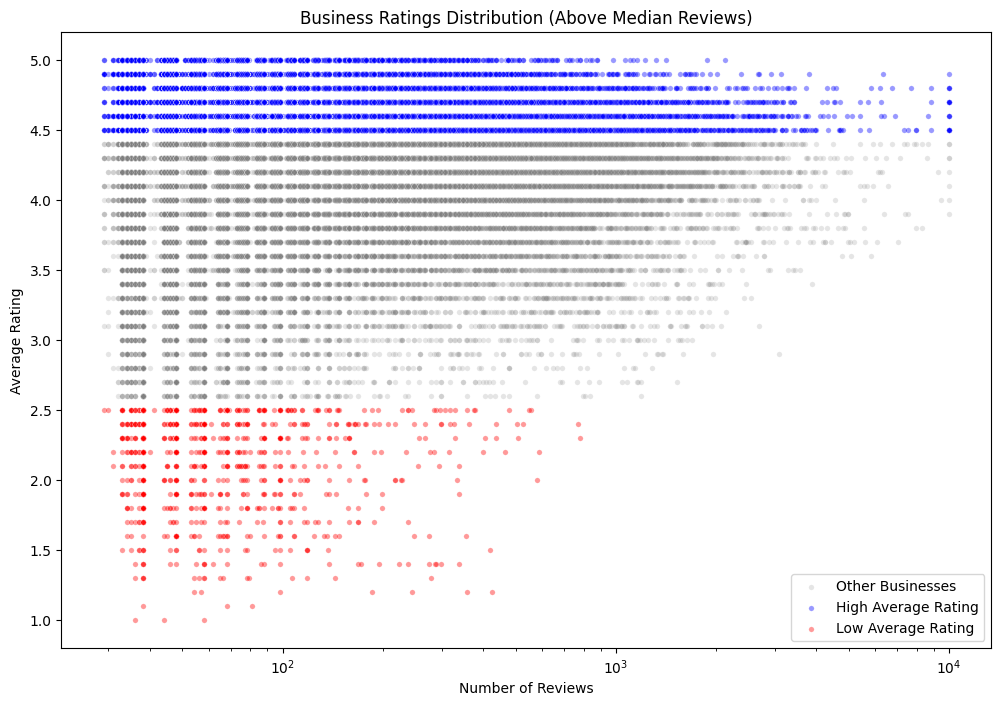

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Define thresholds.
median_num_of_reviews = df['num_of_reviews'].median()
high_avg_rating_threshold = 4.5  # Adjust threshold as needed.
low_avg_rating_threshold = 2.5   # Adjust threshold as needed.

# Filter businesses with reviews greater than median
df_above_median = df[df['num_of_reviews'] > median_num_of_reviews]

# Filter businesses.
many_reviews_high_avg_rating = df_above_median[df_above_median['avg_rating'] >= high_avg_rating_threshold]
many_reviews_low_avg_rating = df_above_median[df_above_median['avg_rating'] <= low_avg_rating_threshold]

# Create a mask for other businesses (above median but not in high or low categories)
other_businesses = df_above_median[
    (df_above_median['avg_rating'] < high_avg_rating_threshold) & 
    (df_above_median['avg_rating'] > low_avg_rating_threshold)
]

# Plotting
plt.figure(figsize=(12, 8))

# Other businesses
sns.scatterplot(
    x=other_businesses['num_of_reviews'],
    y=other_businesses['avg_rating'],
    s=15,  # Point size
    alpha=0.2,  # Transparency
    color='gray',  # Color for other businesses
    label='Other Businesses'
)

# High avg rating businesses
sns.scatterplot(
    x=many_reviews_high_avg_rating['num_of_reviews'],
    y=many_reviews_high_avg_rating['avg_rating'],
    s=15,  # Point size
    alpha=0.4,  # Transparency
    color='blue',  # Color for high avg rating businesses
    label='High Average Rating'
)

# Low avg rating businesses
sns.scatterplot(
    x=many_reviews_low_avg_rating['num_of_reviews'],
    y=many_reviews_low_avg_rating['avg_rating'],
    s=15,  # Point size
    alpha=0.4,  # Transparency
    color='red',  # Color for low avg rating businesses
    label='Low Average Rating'
)

plt.title('Business Ratings Distribution (Above Median Reviews)')
plt.xlabel('Number of Reviews')
plt.ylabel('Average Rating')
plt.xscale('log')  # Use log scale for x-axis to better visualize the distribution
plt.legend()
plt.show()


### Merged from: eda krish.ipynb

In [ ]:
from sqlalchemy import create_engine, text
from sqlalchemy.orm import sessionmaker

# Database connection settings.
DB_HOST = "192.168.1.103"
DB_PORT = "5432"
DB_NAME = "Capstone"
DB_USER = "postgres"
DB_PASSWORD = "Google#13"

# Create engine and session.
engine = create_engine(
    f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}",
    pool_size=20,
    max_overflow=40
)


In [2]:
from sqlalchemy import create_engine, MetaData, Table
from sqlalchemy.orm import sessionmaker
import matplotlib.pyplot as plt
import pandas as pd


In [ ]:
from sqlalchemy import create_engine, MetaData, Table
from sqlalchemy.orm import sessionmaker
import matplotlib.pyplot as plt
import pandas as pd

query = "select user_id, customer_name, time, rating from reviews"
reviews = pd.read_sql(query,engine)




In [ ]:
reviews.head()

,user_id,customer_name,time,rating
0,104432654175532153720,Ashley Midkiff,2017-10-26 00:09:37.058,5.0
1,102706039738339892691,Milly KillnEm,2017-10-30 15:47:23.629,4.0
2,110027878096746344469,Miles Mu,2017-10-29 21:45:14.670,1.0
3,116549850889037513240,robert gemmel,2017-11-01 20:28:44.719,5.0
4,105381178878751201871,Michaveli Rare4orm,2017-11-01 20:28:50.759,4.0


In [ ]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21699421 entries, 0 to 21699420
Data columns (total 4 columns):
 #   Column         Dtype         
---  ------         -----         
 0   user_id        object        
 1   customer_name  object        
 2   time           datetime64[ns]
 3   rating         float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 662.2+ MB


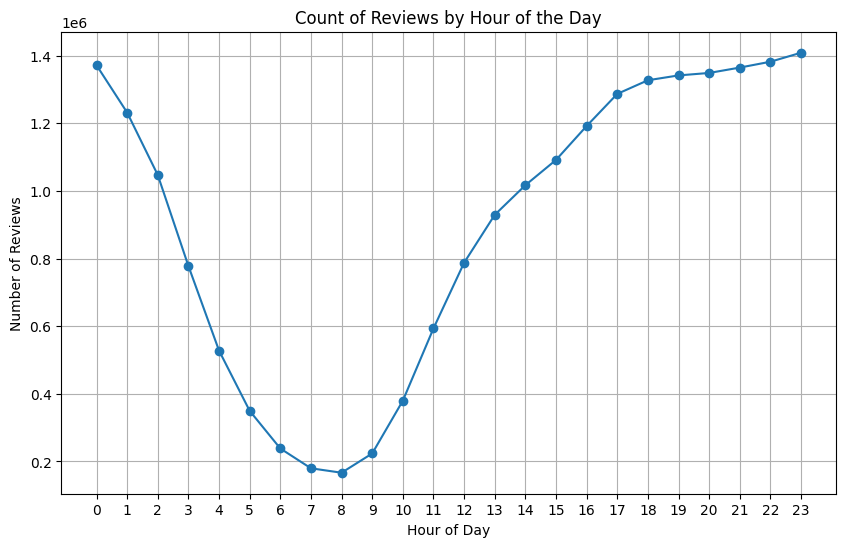

In [ ]:
reviews['hour'] = reviews['time'].dt.hour

# Group by hour and count the number of reviews
hourly_counts = reviews.groupby('hour')['rating'].count().reset_index(name='reviews_count')

# Plot the count of reviews by hour of the day
plt.figure(figsize=(10, 6))
plt.plot(hourly_counts['hour'], hourly_counts['reviews_count'], marker='o', linestyle='-')
plt.title('Count of Reviews by Hour of the Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()

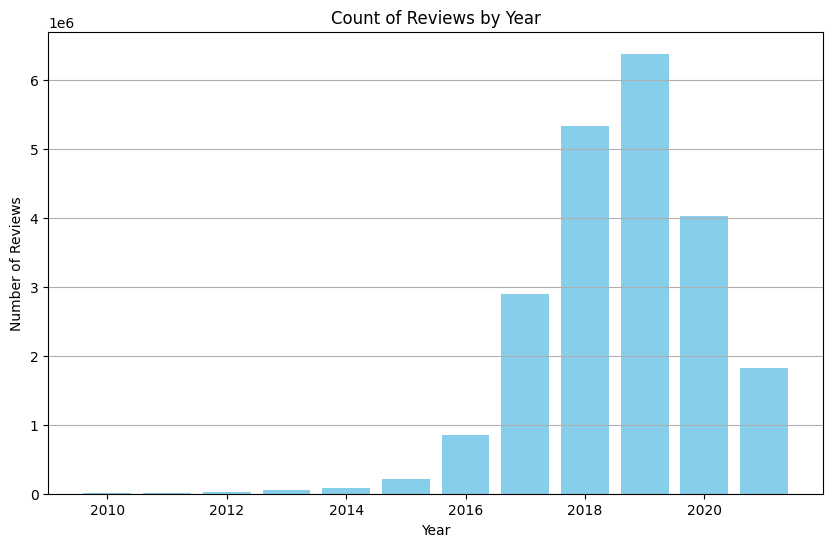

In [ ]:
reviews = reviews[reviews['time'].dt.year >= 2010]
# Group by year and count the number of reviews
reviews['year'] = reviews['time'].dt.year

yearly_counts = reviews.groupby('year').size().reset_index(name='reviews_count')


# Plot the count of reviews by year using a bar chart
plt.figure(figsize=(10, 6))
plt.bar(yearly_counts['year'], yearly_counts['reviews_count'], color='skyblue')
plt.title('Count of Reviews by Year')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.grid(axis='y')
plt.show()

In [ ]:
business = pd.read_sql("select gmap_id, business_name, avg_rating, num_of_reviews, category, price from business", engine)

In [ ]:
business.head()

,gmap_id,business_name,avg_rating,num_of_reviews,category,price
0,0x89c46d5e4554eae1:0xa2f8b211524ca29a,Primo Pizza & Subs,4.5,25,"{""Pizza delivery""}",None
1,0x89c48c790b767ec7:0x1943c20a42196a68,S.J. O’Hara Inc.,4.5,8,"{""HVAC contractor"",""Air conditioning contracto...",None
2,0x89c6c89efcaed69d:0xded973f6033e7dba,Vivi Bubble Tea,4.0,8,{Restaurant},None
3,0x89c6c63c8cd87141:0x54d0d283872eecbb,Kater Street Bicycle,4.9,15,"{""Bicycle Shop"",""Bicycle repair shop""}",None
4,0x89c6c715d1821fe3:0x9cfa8308c0ce2289,Cadence Cycling and Cafe - Center City,4.8,38,"{""Bicycle Shop"",""Bicycle repair shop"",""Coffee ...",None


In [ ]:
business['num_of_reviews'].describe()

count    189836.000000
mean        115.502660
std         314.745819
min           1.000000
25%           8.000000
50%          28.000000
75%          96.000000
max        9998.000000
Name: num_of_reviews, dtype: float64

In [ ]:
business['category'].unique()

array(['{"Pizza delivery"}',
       '{"HVAC contractor","Air conditioning contractor","Air conditioning repair service","Air duct cleaning service","Drainage service","Heating contractor",Plumber}',
       '{Restaurant}', ...,
       '{Supermarket,"Grocery store","Produce wholesaler"}',
       '{"Eastern Orthodox Church",Church,"Greek Orthodox church"}',
       '{"American restaurant","Conference center","Fine dining restaurant",Hotel,Inn,"Wedding venue"}'],
      dtype=object)

In [ ]:
import pandas as pd
import numpy as np
import csv
from io import StringIO
from itertools import chain

# Assuming 'business' is your DataFrame with a 'category' column
# For example:
# business = pd.read_csv('your_business_data.csv')

unique_values = set()

for entry in business['category']:
    # Skip entries that are None
    if entry is None:
        continue
    # Remove outer curly braces if present
    if entry.startswith('{') and entry.endswith('}'):
        entry = entry[1:-1]
    # Use csv.reader to handle comma-separated values and quotes
    f = StringIO(entry)
    reader = csv.reader(f, skipinitialspace=True)
    for row in reader:
        for item in row:
            # Clean each item by stripping whitespace and any surrounding quotes
            cleaned = item.strip().strip('"')
            if cleaned:
                unique_values.add(cleaned)

# Convert the set to a sorted list (optional)
unique_list = sorted(unique_values)
print("Unique values:")
print(unique_list)


Unique values:
['3D printing service', 'ATM', 'ATV dealer', 'ATV rental service', 'ATV repair shop', 'Abbey', 'Abortion clinic', 'Abrasives supplier', 'Accountant', 'Accounting', 'Accounting firm', 'Accounting school', 'Accounting software company', 'Acoustical consultant', 'Acrylic store', 'Acupuncture clinic', 'Acupuncturist', 'Acura dealer', 'Addiction treatment center', 'Administrative attorney', 'Adoption agency', 'Adult DVD store', 'Adult day care center', 'Adult education school', 'Adult entertainment club', 'Adult entertainment store', 'Adult foster care service', 'Adventure sports', 'Adventure sports center', 'Advertising agency', 'Advertising service', 'Aerial photographer', 'Aerial sports center', 'Aerobics instructor', 'Aeroclub', 'Aerospace company', 'Afghani restaurant', 'African goods store', 'African restaurant', 'After school program', 'Aged care', 'Aggregate supplier', 'Agricultural', 'Agricultural association', 'Agricultural cooperative', 'Agricultural machinery manu

In [ ]:
len(unique_list)

3484

In [ ]:
business['category'].isnull().sum()

886

In [ ]:
business.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189836 entries, 0 to 189835
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   gmap_id         189836 non-null  object 
 1   business_name   189836 non-null  object 
 2   avg_rating      189836 non-null  float64
 3   num_of_reviews  189836 non-null  int64  
 4   category        188950 non-null  object 
 5   price           0 non-null       object 
dtypes: float64(1), int64(1), object(4)
memory usage: 8.7+ MB


In [ ]:
c=0
for i in unique_list:
    if 'food' in str(i):
        c+=1
        print(i)

Catering food and drink supplier
Country food restaurant
Dried seafood store
Fast food restaurant
Fresh food market
Frozen food manufacturer
Frozen food store
Health food restaurant
Health food store
Organic food store
Pet food and animal feeds
Raw food restaurant
Seafood
Seafood market
Seafood restaurant
Seafood store
Seafood wholesaler
Soul food restaurant
Wholesale food store


In [ ]:
ulist = pd.DataFrame(unique_list)

In [ ]:
import pandas as pd

mapping = {
    'Food': [
        'restaurant', 'pizza', 'cafe', 'bakery', 'diner', 'bistro', 'fast food', 
        'sandwich', 'steakhouse', 'barbecue', 'pizzeria', 'food', 'grill', 'buffet'
    ],
    'Home Services': [
        'plumber', 'hvac', 'air conditioning', 'heating', 'air duct', 'drainage',
        'electrician', 'handyman', 'pest control', 'cleaning', 'landscaping',
        'maintenance', 'repair', 'home improvement', 'moving', 'contractor'
    ],
    'Retail': [
        'supermarket', 'store', 'boutique', 'clothing', 'fashion', 'retail', 'shop',
        'mall', 'market', 'discount', 'department store', 'outlet', 'apparel'
    ],
    'Religious': [
        'church', 'temple', 'mosque', 'synagogue', 'orthodox', 'ministry', 'cathedral', 
        'chapel', 'religious'
    ],
    'Hospitality': [
        'hotel', 'inn', 'motel', 'resort', 'lodging', 'accommodation', 'bed and breakfast',
        'wedding', 'conference', 'banquet', 'hostel'
    ],
    'Rental Service': [
        'rental', 'lease', 'apartments', 'housing', 'real estate', 'landlord', 
        'property', 'leasing', 'vacation rental', 'short term', 'rental service'
    ],
    'Health & Medical': [
        'health', 'medical', 'dentist', 'doctor', 'clinic', 'hospital', 'urgent care',
        'pharmacy', 'wellness', 'chiropractic', 'optometrist', 'physician', 'veterinary',
        'therapy', 'mental health'
    ],
    'Automotive': [
        'auto', 'car', 'repair', 'mechanic', 'dealership', 'car wash', 'tire', 'garage',
        'automotive', 'vehicle', 'motorcycle', 'truck', 'auto service', 'oil change'
    ],
    'Entertainment & Arts': [
        'theater', 'cinema', 'movie', 'museum', 'gallery', 'concert', 'performance',
        'music', 'dance', 'club', 'entertainment', 'art', 'live', 'show', 'comedy'
    ],
    'Professional Services': [
        'law', 'attorney', 'accountant', 'legal', 'consulting', 'architect', 'engineer',
        'agency', 'business services', 'consultant', 'financial advisor', 'marketing'
    ],
    'Education': [
        'school', 'college', 'university', 'institute', 'tutoring', 'education', 'training',
        'learning center', 'academy', 'class', 'course'
    ],
    'Beauty & Spas': [
        'beauty', 'spa', 'salon', 'barber', 'cosmetics', 'hair', 'nail', 'massage',
        'aesthetics', 'makeup', 'skincare'
    ],
    'Sports & Recreation': [
        'gym', 'fitness', 'sport', 'recreation', 'athletic', 'club', 'stadium', 'park',
        'yoga', 'martial arts', 'fitness center', 'outdoor', 'cycling', 'swimming'
    ],
    'Travel & Transportation': [
        'travel', 'airport', 'transportation', 'taxi', 'limo', 'shuttle', 'bus', 
        'railway', 'train', 'flight', 'airline', 'car rental', 'transit', 'commute'
    ],
    'Technology': [
        'tech', 'computer', 'electronics', 'it', 'software', 'hardware', 'repair',
        'mobile', 'gadget', 'telecom', 'internet'
    ],
    'Home & Garden': [
        'furniture', 'home decor', 'garden', 'landscaping', 'interior design',
        'home improvement', 'decor', 'housewares'
    ],
    'Financial Services': [
        'bank', 'insurance', 'finance', 'investment', 'financial', 'money', 'mortgage',
        'credit', 'loan', 'accounting', 'capital'
    ],
    'Arts & Crafts': [
        'art', 'craft', 'supplies', 'studio', 'handmade', 'crafts', 'design', 'gallery'
    ],
    'Miscellaneous': [
        'miscellaneous', 'other', 'general', 'variety', 'everything', 'all others'
    ]
}

def map_category(sub_category):
    """Map a single subcategory string to a main category using the mapping dictionary."""
    sub_category_lower = sub_category.lower()
    for main_cat, keywords in mapping.items():
        if any(keyword in sub_category_lower for keyword in keywords):
            return main_cat
    return 'Other'

def parse_and_map_categories(category_str):
    """
    Convert the string representation of subcategories into a list,
    then map each subcategory to its main category.
    Returns a sorted list of unique main categories.
    """
    if pd.isnull(category_str):
        return None

    if category_str.startswith('{') and category_str.endswith('}'):
        category_str = category_str[1:-1]

    f = StringIO(category_str)
    reader = csv.reader(f, skipinitialspace=True)
    subcategories = []
    for row in reader:
        for item in row:
            cleaned = item.strip().strip('"')
            if cleaned:
                subcategories.append(cleaned)
                
    main_categories = set(map(map_category, subcategories))
    return sorted(main_categories)

business['main_category'] = business['category'].apply(parse_and_map_categories)


In [ ]:
business.head()

,gmap_id,business_name,avg_rating,num_of_reviews,category,price,main_category
0,0x89c46d5e4554eae1:0xa2f8b211524ca29a,Primo Pizza & Subs,4.5,25,"{""Pizza delivery""}",None,[Food]
1,0x89c48c790b767ec7:0x1943c20a42196a68,S.J. O’Hara Inc.,4.5,8,"{""HVAC contractor"",""Air conditioning contracto...",None,[Home Services]
2,0x89c6c89efcaed69d:0xded973f6033e7dba,Vivi Bubble Tea,4.0,8,{Restaurant},None,[Food]
3,0x89c6c63c8cd87141:0x54d0d283872eecbb,Kater Street Bicycle,4.9,15,"{""Bicycle Shop"",""Bicycle repair shop""}",None,"[Home Services, Retail]"
4,0x89c6c715d1821fe3:0x9cfa8308c0ce2289,Cadence Cycling and Cafe - Center City,4.8,38,"{""Bicycle Shop"",""Bicycle repair shop"",""Coffee ...",None,"[Home Services, Retail]"


In [ ]:
df_exploded = business.explode('main_category')
binary_matrix = pd.crosstab(df_exploded['gmap_id'], df_exploded['main_category'])

binary_matrix = (binary_matrix > 0).astype(int)

result = business.merge(binary_matrix, on='gmap_id', how='left')

In [ ]:

pd.set_option('display.max_columns', None)


In [ ]:
result.to_csv('cleaned_business.csv')

Category Statistics:
          main_category  num_businesses  avg_rating  avg_num_reviews  \
0         Arts & Crafts            1192    4.629279        46.011745   
1            Automotive           13552    4.302037        96.729486   
2         Beauty & Spas            8644    4.481941        57.873554   
3             Education            2905    4.320138        61.454045   
4  Entertainment & Arts            8394    4.300036       147.981296   

   total_reviews  
0          54846  
1        1310878  
2         500259  
3         178524  
4        1242155  


C:\Users\rushi\AppData\Local\Temp\ipykernel_37488\3912431162.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_categories, x='num_businesses', y='main_category', palette='viridis')


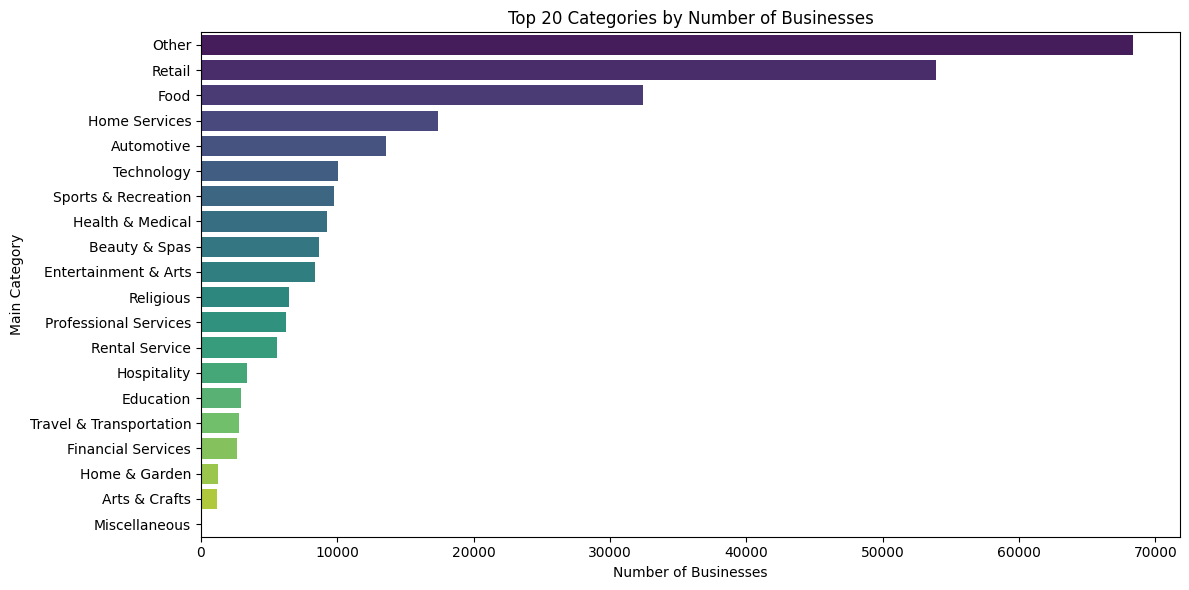

C:\Users\rushi\AppData\Local\Temp\ipykernel_37488\3912431162.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_categories, x='avg_rating', y='main_category', palette='magma')


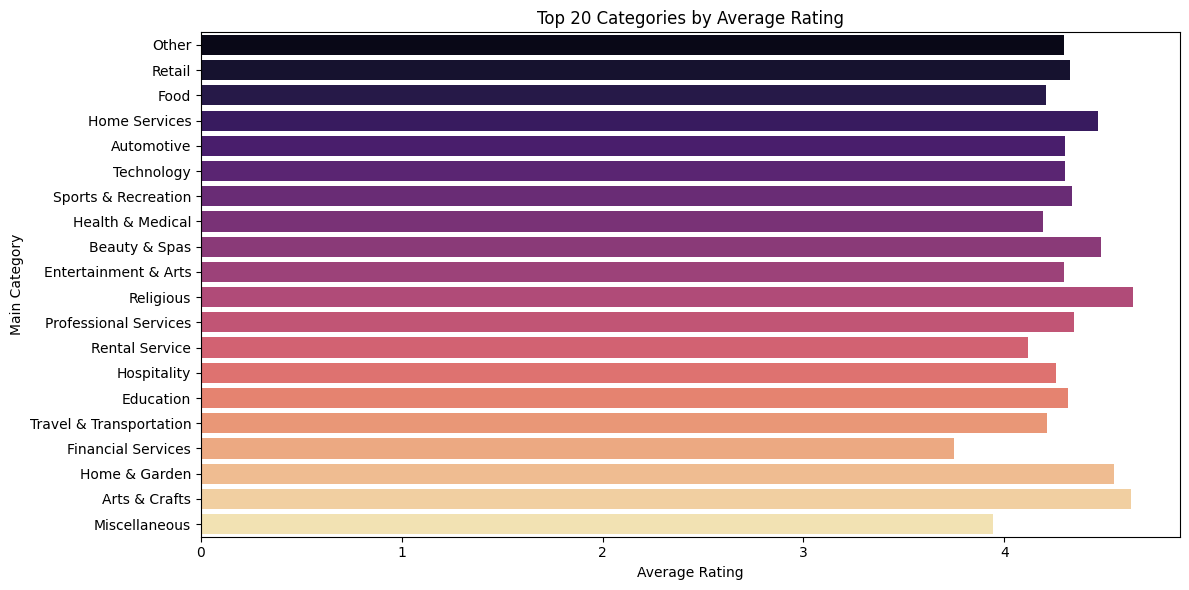

C:\Users\rushi\AppData\Local\Temp\ipykernel_37488\3912431162.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_categories, x='avg_num_reviews', y='main_category', palette='coolwarm')


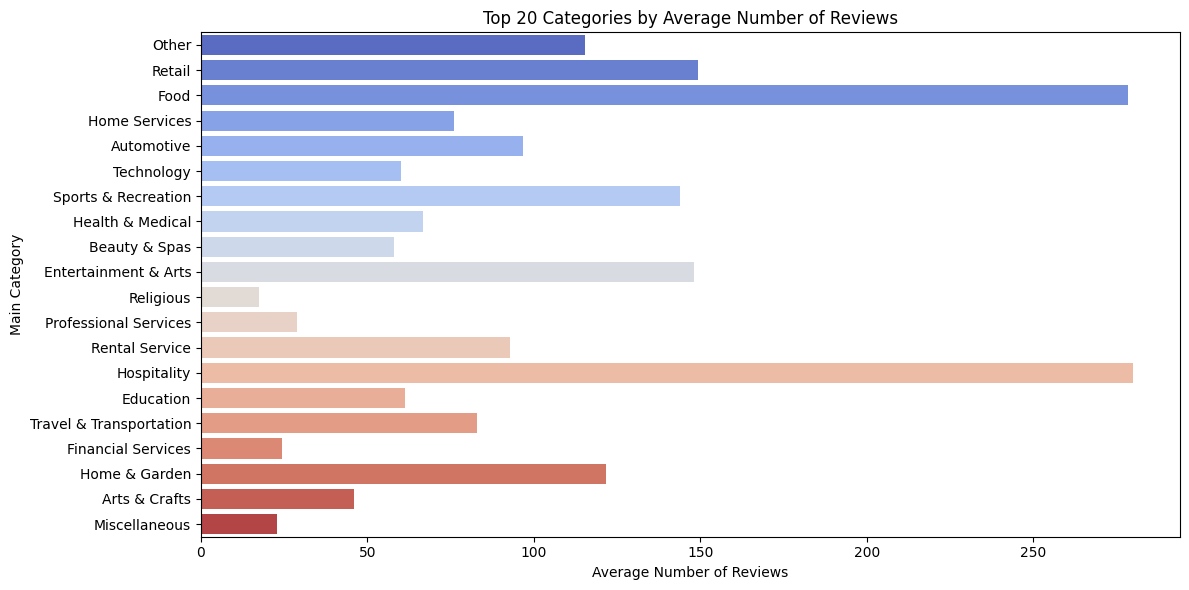

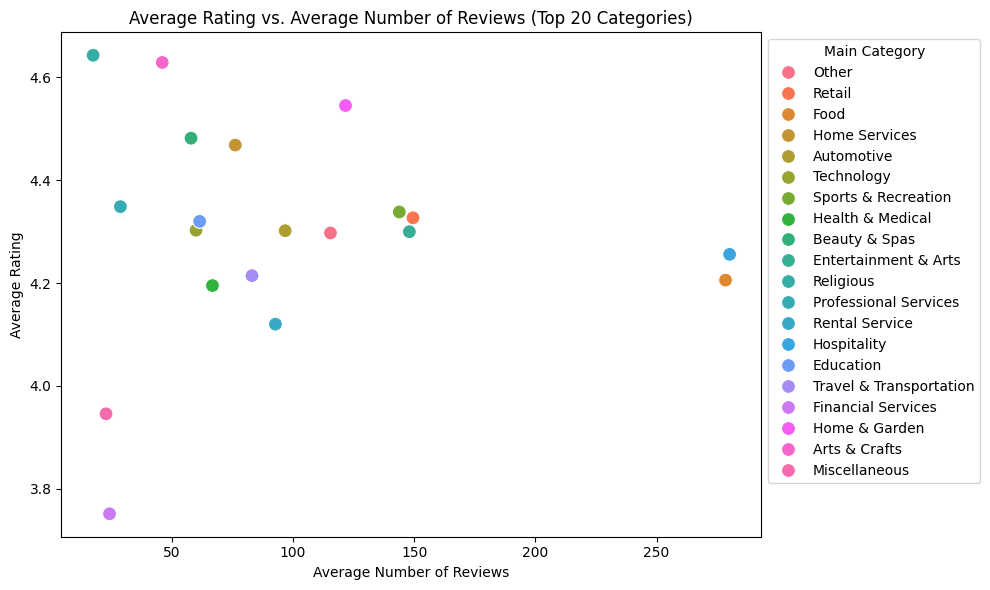

In [ ]:
import seaborn as sns

df_exploded = result.explode('main_category')
df_exploded['main_category'] = df_exploded['main_category'].str.strip()

category_stats = df_exploded.groupby('main_category').agg(
    num_businesses=('gmap_id', 'nunique'),
    avg_rating=('avg_rating', 'mean'),
    avg_num_reviews=('num_of_reviews', 'mean'),
    total_reviews=('num_of_reviews', 'sum')
).reset_index()

print("Category Statistics:")
print(category_stats.head())

top_categories = category_stats.sort_values('num_businesses', ascending=False).head(20)
plt.figure(figsize=(12,6))
sns.barplot(data=top_categories, x='num_businesses', y='main_category', color='skyblue')
plt.title('Top 20 Categories by Number of Businesses')
plt.xlabel('Number of Businesses')
plt.ylabel('Main Category')
plt.tight_layout()
plt.show()

# Plot 2: Bar chart of the average rating per category
plt.figure(figsize=(12,6))
sns.barplot(data=top_categories, x='avg_rating', y='main_category', color='salmon')
plt.title('Top 20 Categories by Average Rating')
plt.xlabel('Average Rating')
plt.ylabel('Main Category')
plt.tight_layout()
plt.show()

# Plot 3: Bar chart of the average number of reviews per category
plt.figure(figsize=(12,6))
sns.barplot(data=top_categories, x='avg_num_reviews', y='main_category', color='lightgreen')
plt.title('Top 20 Categories by Average Number of Reviews')
plt.xlabel('Average Number of Reviews')
plt.ylabel('Main Category')
plt.tight_layout()
plt.show()

# Plot 4: Scatter plot of average rating vs. average number of reviews for the top categories
plt.figure(figsize=(10,6))
sns.scatterplot(data=top_categories, x='avg_num_reviews', y='avg_rating', color='purple', s=100)
plt.title('Average Rating vs. Average Number of Reviews (Top 20 Categories)')
plt.xlabel('Average Number of Reviews')
plt.ylabel('Average Rating')
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

df = pd.read_csv(r"C:\MS_DS\RG_Winter25\Capstone 1 DSCI 591\cleaned_business.csv")

In [ ]:
df.head()

,Unnamed: 0,gmap_id,business_name,avg_rating,num_of_reviews,category,price,main_category,Arts & Crafts,Automotive,...,Hospitality,Miscellaneous,Other,Professional Services,Religious,Rental Service,Retail,Sports & Recreation,Technology,Travel & Transportation
0,0,0x89c46d5e4554eae1:0xa2f8b211524ca29a,Primo Pizza & Subs,4.5,25,"{""Pizza delivery""}",NaN,['Food'],0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0x89c48c790b767ec7:0x1943c20a42196a68,S.J. O’Hara Inc.,4.5,8,"{""HVAC contractor"",""Air conditioning contracto...",NaN,['Home Services'],0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0x89c6c89efcaed69d:0xded973f6033e7dba,Vivi Bubble Tea,4.0,8,{Restaurant},NaN,['Food'],0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0x89c6c63c8cd87141:0x54d0d283872eecbb,Kater Street Bicycle,4.9,15,"{""Bicycle Shop"",""Bicycle repair shop""}",NaN,"['Home Services', 'Retail']",0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,4,0x89c6c715d1821fe3:0x9cfa8308c0ce2289,Cadence Cycling and Cafe - Center City,4.8,38,"{""Bicycle Shop"",""Bicycle repair shop"",""Coffee ...",NaN,"['Home Services', 'Retail']",0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
from sqlalchemy import create_engine, text
from sqlalchemy.orm import sessionmaker

# Database connection settings.
DB_HOST = "192.168.1.103"
DB_PORT = "5432"
DB_NAME = "Capstone"
DB_USER = "postgres"
DB_PASSWORD = "Google#13"

# Create engine and session.
engine = create_engine(
    f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}",
    pool_size=20,
    max_overflow=40
)


In [ ]:
from sqlalchemy import create_engine, MetaData, Table
from sqlalchemy.orm import sessionmaker
import matplotlib.pyplot as plt
import pandas as pd



In [ ]:
query = "select user_id, customer_name, first_review_date, last_review_date, total_reviews, avg_rating as user_avg_rating from users"
users = pd.read_sql(query,engine)


In [ ]:
query = "select user_id, time, rating, gmap_id, customer_name from reviews"
reviews = pd.read_sql(query,engine)


C:\Users\rushi\AppData\Local\Temp\ipykernel_55724\752561957.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df, x='avg_rating', shade=True, color='blue')


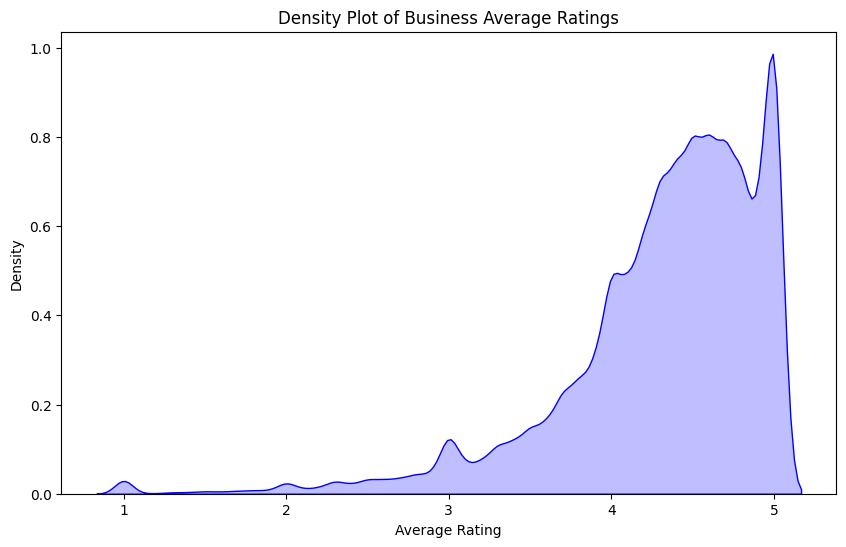

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='avg_rating', shade=True, color='blue')
plt.title("Density Plot of Business Average Ratings")
plt.xlabel("Average Rating")
plt.ylabel("Density")
plt.show()

In [ ]:
users.head()

,user_id,customer_name,first_review_date,last_review_date,total_reviews,user_avg_rating
0,118446717614999951016,James Billings,2015-06-07 21:52:40.740,2015-06-07 21:52:40.740,1,5.0
1,118446725185281394757,Jodie Hayford,2017-07-23 00:53:57.977,2017-07-23 00:53:57.977,1,3.0
2,118446696946959024765,russell zarzeczny,2019-12-30 02:16:31.395,2019-12-30 02:16:31.395,1,1.0
3,118446703820689773600,Emma Johnson,2019-07-16 15:17:56.371,2019-07-16 15:17:56.371,1,5.0
4,118446683655957264030,John Riley,2018-11-20 02:39:36.713,2018-11-20 02:39:36.713,1,5.0


C:\Users\rushi\AppData\Local\Temp\ipykernel_56700\3365263471.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_top['year_month'] = reviews_top['time'].dt.to_period('M').dt.to_timestamp()


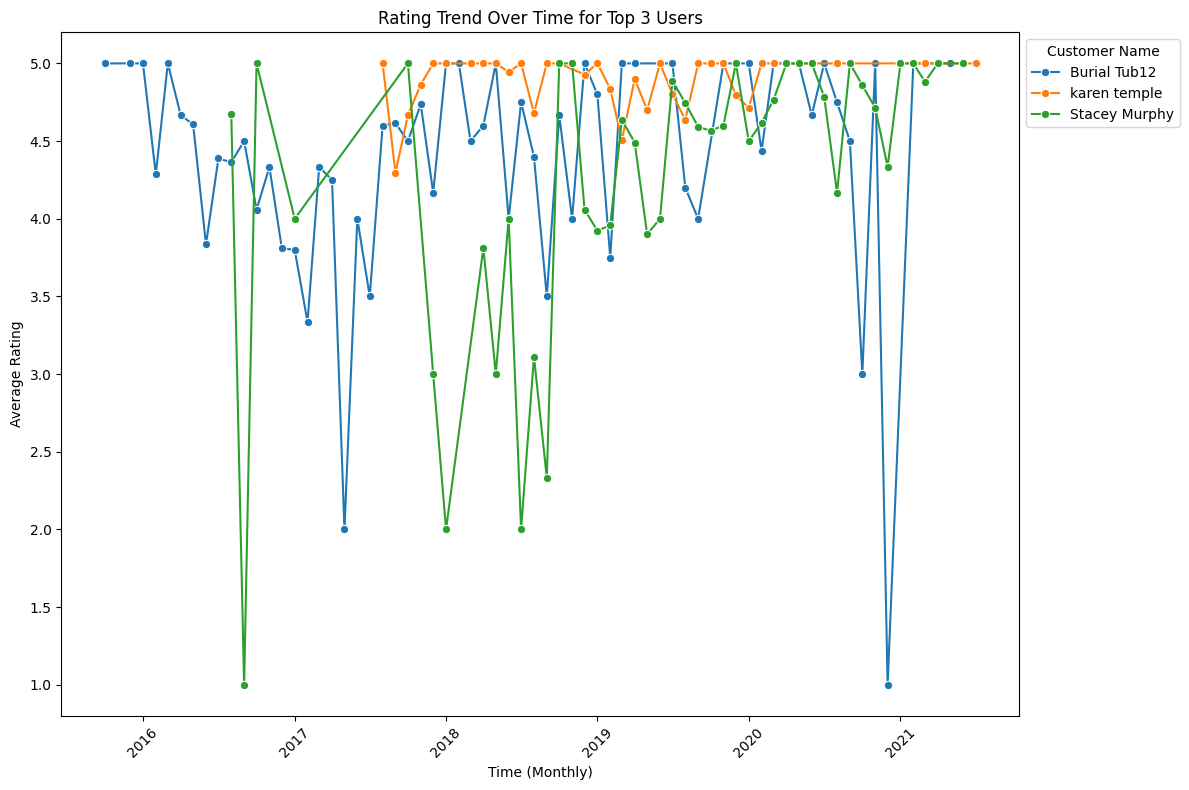

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
top_users = users.sort_values('total_reviews', ascending=False).head(3)
top_user_ids = top_users['user_id'].tolist()
reviews_top = reviews[reviews['user_id'].isin(top_user_ids)]

reviews_top['year_month'] = reviews_top['time'].dt.to_period('M').dt.to_timestamp()

user_rating_trend = reviews_top.groupby(['user_id', 'year_month'])['rating'].mean().reset_index()

user_rating_trend = user_rating_trend.merge(users[['user_id', 'customer_name']], on='user_id', how='left')


plt.figure(figsize=(12, 8))
sns.lineplot(data=user_rating_trend, x='year_month', y='rating', hue='customer_name', marker='o')
plt.title("Rating Trend Over Time for Top 3 Users")
plt.xlabel("Time (Monthly)")
plt.ylabel("Average Rating")
plt.xticks(rotation=45)
plt.legend(title='Customer Name', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

### Merged from: main_eda.ipynb

In [ ]:
from sqlalchemy import create_engine, text
from sqlalchemy.orm import sessionmaker

# Database connection settings.
DB_HOST = "192.168.1.103"
DB_PORT = "5432"
DB_NAME = "Capstone"
DB_USER = "postgres"
DB_PASSWORD = "Google#13"

# Create engine and session.
engine = create_engine(
    f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}",
    pool_size=20,
    max_overflow=40
)
Session = sessionmaker(bind=engine)
session = Session()

In [2]:
from sqlalchemy import create_engine, MetaData, Table
from sqlalchemy.orm import sessionmaker
import matplotlib.pyplot as plt
import pandas as pd


                 user_id  user_lifetime_days review_frequency
0  117132441140924509158                   1             1.00
1  117132449439104655116                   1             1.00
2  117436616885346310790                 784             3.00
3  117132471438625433716                   1             1.00
4  117436619310229111035                3118            11.00


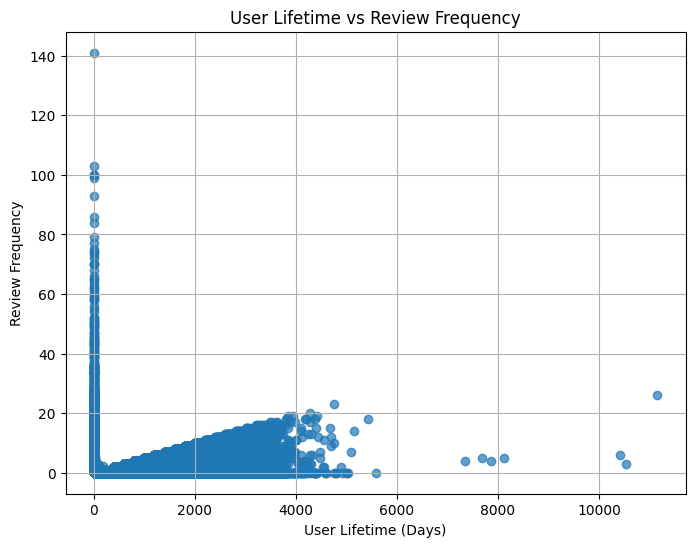

In [ ]:

metadata = MetaData()
users = Table('users', metadata, autoload_with=engine)
# Query the columns: user_id, user_lifetime_days, and review_frequency
query = session.query(
    users.c.user_id,
    users.c.user_lifetime_days,
    users.c.review_frequency
)
results = query.all()

# Convert the query results to a pandas DataFrame for easier plotting
df = pd.DataFrame(results, columns=["user_id", "user_lifetime_days", "review_frequency"])

# Print the first few rows of the DataFrame (optional)
print(df.head())

# Create a scatter plot: user_lifetime_days vs review_frequency
plt.figure(figsize=(8, 6))
plt.scatter(df['user_lifetime_days'], df['review_frequency'], alpha=0.7)
plt.xlabel('User Lifetime (Days)')
plt.ylabel('Review Frequency')
plt.title('User Lifetime vs Review Frequency')
plt.grid(True)
plt.show()



### Merged from: pyspark.ipynb

In [ ]:
from pyspark.sql import SparkSession

# Initialize Spark Session
spark = SparkSession.builder.appName("ReadJSON").getOrCreate()

# Read JSON file into DataFrame
review = spark.read.json(r"C:\MS DS\RG_Winter25\Capstone 1 DSCI 591\data\review-Pennsylvania.json\review-Pennsylvania.json")
meta = spark.read.json(r"C:\MS DS\RG_Winter25\Capstone 1 DSCI 591\data\meta-Pennsylvania.json\meta-Pennsylvania.json")


# Show DataFrame
meta.show()


+--------------------+--------------------+----------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+--------------------+--------------+-----+--------------------+--------------------+--------------------+
|                MISC|             address|avg_rating|            category|         description|             gmap_id|               hours|          latitude|         longitude|                name|num_of_reviews|price|    relative_results|               state|                 url|
+--------------------+--------------------+----------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+--------------------+--------------+-----+--------------------+--------------------+--------------------+
|{NULL, NULL, NULL...|Primo Pizza & Sub...|       4.5|    [Pizza delivery]|                NULL|0x89c46d5e4554eae...|[[Thursday, 11AM–...|        40.68217

In [32]:
review.show()


+--------------------+------------------+----+------+----+--------------------+-------------+--------------------+
|             gmap_id|              name|pics|rating|resp|                text|         time|             user_id|
+--------------------+------------------+----+------+----+--------------------+-------------+--------------------+
|0x89c46d5e4554eae...|   Jennifer Cordón|NULL|     5|NULL|Just had the Germ...|1630529977304|10241275264630097...|
|0x89c46d5e4554eae...|     Luis Gonzalez|NULL|     5|NULL|Great food, and g...|1630544172046|10330038687874311...|
|0x89c46d5e4554eae...|     Jasson Cordon|NULL|     5|NULL|Good food and fai...|1631012728526|10471584331703059...|
|0x89c46d5e4554eae...|     Sharon Mendez|NULL|     5|NULL|Very good service...|1630460639875|10772877940368786...|
|0x89c46d5e4554eae...|  Salvador Fuentes|NULL|     5|NULL|Great food and se...|1630435490430|10879752391481534...|
|0x89c46d5e4554eae...|     Kevin Fuentes|NULL|     5|NULL|Good service and ...|1

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, lit, lower, regexp_replace, trim, udf
from pyspark.sql.types import StringType, FloatType, TimestampType
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import json

# # Initialize Spark Session
spark = SparkSession.builder \
    .appName("ReadJSON") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

# Read JSON files into PySpark DataFrames
reviews = spark.read.json(r"C:\MS DS\RG_Winter25\Capstone 1 DSCI 591\data\review-Pennsylvania.json")
meta = spark.read.json(r"C:\MS DS\RG_Winter25\Capstone 1 DSCI 591\data\meta-Pennsylvania.json")

# Display schema
review.printSchema()
meta.printSchema()


# Rename 'name' column in reviews and metadata to avoid conflicts
reviews = review.withColumnRenamed("name", "reviewer_name")
metadata = meta.withColumnRenamed("name", "business_name")

# Merge the datasets on 'gmap_id'
merged_df = reviews.join(metadata, on="gmap_id", how="inner")

from pyspark.sql.functions import col, when, to_json

from pyspark.sql.functions import col, when, to_json

# Ensure `resp` is a STRUCT before converting to JSON
if "resp" in merged_df.columns:
    resp_dtype = dict(merged_df.dtypes)["resp"]  # Get column type
    if "struct" in resp_dtype.lower():
        merged_df = merged_df.withColumn("resp", to_json(col("resp")))



from pyspark.sql.functions import col, when

misc_df = merged_df.select("gmap_id", "MISC", "hours", "relative_results")

# 2) Drop the three columns from the main dataframe
merged_df = merged_df.drop("MISC", "hours", "relative_results")

# Define column groups
text_columns = ["text", "description", "resp"]  # Fill with empty string ""







root
 |-- gmap_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- pics: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- url: array (nullable = true)
 |    |    |    |-- element: string (containsNull = true)
 |-- rating: long (nullable = true)
 |-- resp: struct (nullable = true)
 |    |-- text: string (nullable = true)
 |    |-- time: long (nullable = true)
 |-- text: string (nullable = true)
 |-- time: long (nullable = true)
 |-- user_id: string (nullable = true)

root
 |-- MISC: struct (nullable = true)
 |    |-- Accessibility: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Activities: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Amenities: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Atmosphere: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Crowd: array (nullable =